* VAE: https://blog.keras.io/building-autoencoders-in-keras.html
* VAE2: https://github.com/keras-team/keras/blob/master/examples/variational_autoencoder_deconv.py
* GAN: https://www.kdnuggets.com/2016/07/mnist-generative-adversarial-model-keras.html
* GAN2: https://towardsdatascience.com/gan-by-example-using-keras-on-tensorflow-backend-1a6d515a60d0

[1] Kingma, D. P., & Welling, M. (2013). *Auto-encoding variational bayes*. arXiv preprint arXiv:1312.6114.  
[2] Goodfellow, I., Pouget-Abadie, J., Mirza, M., Xu, B., Warde-Farley, D., Ozair, S., ... & Bengio, Y. (2014). *Generative adversarial nets*. In Advances in neural information processing systems (pp. 2672-2680).

In [2]:
from keras.datasets import mnist
import numpy as np
import keras.backend as K
import keras
img_rows, img_cols,channel = 28, 28, 1

# the data, shuffled and split between train and test sets
(X_train, y_train), (X_test, y_test) = mnist.load_data()
X_train = X_train.astype('float32')
X_test = X_test.astype('float32')
X_train /= 255
X_test /= 255

print np.min(X_train), np.max(X_train)

print('X_train shape:', X_train.shape)
print(X_train.shape[0], 'train samples')
print(X_test.shape[0], 'test samples')

0.0 1.0
('X_train shape:', (60000, 28, 28))
(60000, 'train samples')
(10000, 'test samples')


## VAE
entender un poco  

prior tambien en $p_{\theta}(z)$

Min la reconstrucción (aleatoria) con una medición de error (*mse* o binary cross entropy para datos entre 0 y 1) + una regularización que se impone que la distribución aprendida (z) sea una Normal multivariada con media vector de ceros y la matriz de covarianza la matriz identidad

$$
Min \ KL( q_{\hat{\theta}}(z\mid x) \mid \mid p_{\theta}(z)) + L(q_{\hat{\theta}}(x\mid z),x)
$$
https://i.imgur.com/ZN6MyTx.png

In [158]:
###FEED FORWARD VAE
from keras.layers import Input,Dense,Lambda
from keras.models import Model

X_train = X_train.reshape(X_train.shape[0],img_rows*img_cols)
X_test = X_test.reshape(X_test.shape[0],img_rows*img_cols)

original_dim = X_train.shape[1:][0]
intermediate_dim = 256
## Encoder
x = Input(shape=(original_dim,))
h = Dense(intermediate_dim, activation='relu')(x)
z_mean = Dense(latent_dim)(h)
z_log_sigma = Dense(latent_dim)(h)
def sampling(args): #from normal
    epsilon_std = 1
    z_mean, z_log_sigma = args
    epsilon = K.random_normal(shape=(K.shape(z_mean)[0],latent_dim), mean=0.,stddev=epsilon_std)
    return z_mean + K.exp(z_log_sigma / 2) * epsilon
# note that "output_shape" isn't necessary with the TensorFlow backend
# so you could write `Lambda(sampling)([z_mean, z_log_sigma])`
z = Lambda(sampling, output_shape=(latent_dim,))([z_mean, z_log_sigma])
## Decoder
decoder_h = Dense(intermediate_dim, activation='relu')
decoder_mean = Dense(original_dim, activation='sigmoid')
h_decoded = decoder_h(z)
x_decoded_mean = decoder_mean(h_decoded)

# end-to-end autoencoder
vae = Model(x, x_decoded_mean)

# encoder, from inputs to latent space
encoder = Model(x, z_mean)

# generator, from latent space to reconstructed inputs
decoder_input = Input(shape=(latent_dim,))
_h_decoded = decoder_h(decoder_input)
_x_decoded_mean = decoder_mean(_h_decoded)
generator = Model(decoder_input, _x_decoded_mean)

# Compute VAE loss
xent_loss = keras.metrics.binary_crossentropy(x, x_decoded_mean) * original_dim #amplifica por cada componente
kl_loss = - 0.5 * K.sum(1 + z_log_sigma - K.square(z_mean) - K.exp(z_log_sigma), axis=-1)#entre z y N(0,1)
vae_loss = K.mean(xent_loss + kl_loss)
vae.add_loss(vae_loss)

vae.compile(optimizer='rmsprop')

vae.summary()

batch_size = 124
vae.fit(X_train, epochs=50, batch_size=batch_size,validation_data=(X_test, None))

/home/casapanshop/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:47: UserWarning: Output "dense_104" missing from loss dictionary. We assume this was done on purpose, and we will not be expecting any data to be passed to "dense_104" during training.


__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_35 (InputLayer)           (None, 784)          0                                            
__________________________________________________________________________________________________
dense_100 (Dense)               (None, 256)          200960      input_35[0][0]                   
__________________________________________________________________________________________________
dense_101 (Dense)               (None, 2)            514         dense_100[0][0]                  
__________________________________________________________________________________________________
dense_102 (Dense)               (None, 2)            514         dense_100[0][0]                  
__________________________________________________________________________________________________
lambda_19 

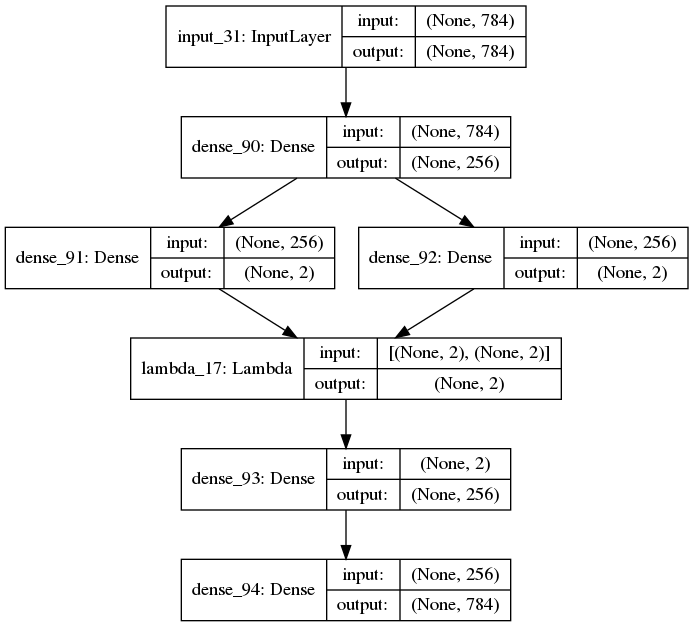

In [141]:
from keras.utils import plot_model
plot_model(vae, to_file='model.png',show_shapes=True)
from IPython.display import Image
Image(filename='model.png')

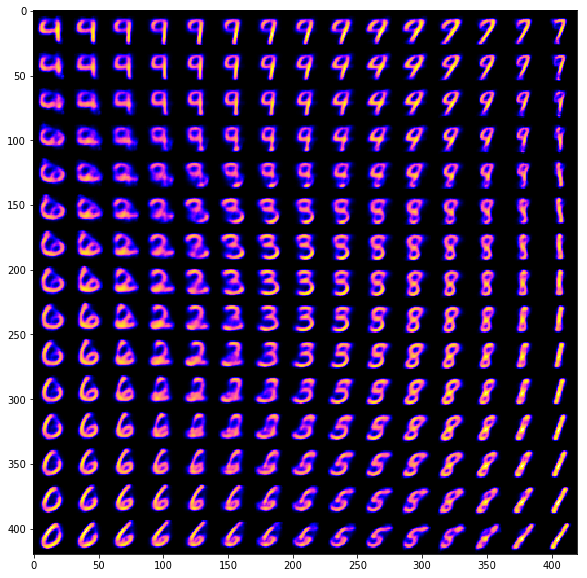

In [162]:
# display a 2D manifold of the digits
n = 15  # figure with 15x15 digits
digit_size = 28
figure = np.zeros((digit_size * n, digit_size * n))
# linearly spaced coordinates on the unit square were transformed through the inverse CDF (ppf) of the Gaussian
# to produce values of the latent variables z, since the prior of the latent space is Gaussian

# Construct grid of latent variable values
grid_x = norm.ppf(np.linspace(0.05, 0.95, n))
grid_y = norm.ppf(np.linspace(0.05, 0.95, n))

for i, yi in enumerate(grid_x):
    for j, xi in enumerate(grid_y):
        z_sample = np.array([[xi, yi]])
        x_decoded = generator.predict(z_sample)
        digit = x_decoded[0].reshape(digit_size, digit_size)
        figure[i * digit_size: (i + 1) * digit_size,
               j * digit_size: (j + 1) * digit_size] = digit

plt.figure(figsize=(10, 10))
plt.imshow(figure,cmap='gnuplot2')
plt.show()

In [5]:
# input image dimensions
original_img_size = (img_rows, img_cols,channel)

# number of convolutional filters to use
filters = 32
# convolution kernel size
num_conv = 3
latent_dim = 2
intermediate_dim = 128
epsilon_std = 1.0

In [6]:
from keras.layers import Input,Conv2D,Flatten,Dense,MaxPool2D
from keras.models import Model
## Encoder
x = Input(shape=original_img_size)
conv_1 = Conv2D(filters,kernel_size=num_conv,padding='same', activation='relu')(x)
conv_2 = Conv2D(filters,kernel_size=num_conv,padding='same', activation='relu')(conv_1)
conv_3 = Conv2D(filters*2, kernel_size=num_conv, padding='same', activation='relu', strides=2)(conv_2)
#conv_4 = Conv2D(filters,kernel_size=num_conv, padding='same', activation='relu')(conv_2)
#pool = MaxPool2D((2,2))(conv_2)
#maxpooling
flat = Flatten()(conv_3)
hidden = Dense(intermediate_dim, activation='relu')(flat)

z_mean = Dense(latent_dim,activation='linear')(hidden)
z_log_var = Dense(latent_dim,activation='linear')(hidden)
# build a model to project inputs on the latent space
encoder = Model(x, z_mean)

In [7]:
from keras.layers import Reshape,Conv2DTranspose,Activation
## Decoder

shape_before_flattening = K.int_shape(conv_3)[1:]

# we instantiate these layers separately so as to reuse them later
decoder_hid = Dense(intermediate_dim, activation='relu')
decoder_upsample = Dense(np.prod(shape_before_flattening), activation='relu')
decoder_reshape = Reshape(shape_before_flattening)

#decoder_deconv_1 = Conv2DTranspose(filters,kernel_size=num_conv,padding='same',strides=(2,2), activation='relu')
#upsampling = UpSampling2D((2,2))

#decoder_deconv_3_upsamp = Conv2DTranspose(filters,kernel_size=(3, 3),strides=(2, 2), padding='valid',activation='relu')
decoder_deconv_1 = Conv2DTranspose(filters,kernel_size=num_conv, padding='same',strides=2,activation='relu')
decoder_deconv_2 = Conv2DTranspose(filters,kernel_size=num_conv,padding='same', activation='relu')

decoder_mean_squash = Conv2DTranspose(channel, kernel_size=num_conv,padding='same', activation='sigmoid') #conv1d normal


In [8]:
def sampling(args):
    epsilon_std = 1.0
    z_mean, z_log_var = args
    epsilon = K.random_normal(shape=(K.shape(z_mean)[0], latent_dim),mean=0., stddev=epsilon_std)
    return z_mean + K.exp(z_log_var) * epsilon
from keras.layers import Lambda
z = Lambda(sampling, output_shape=(latent_dim,))([z_mean, z_log_var])

hid_decoded = decoder_hid(z)
up_decoded = decoder_upsample(hid_decoded)
reshape_decoded =  decoder_reshape(up_decoded)
deconv_1_decoded = decoder_deconv_1(reshape_decoded)
x_decoded_relu = decoder_deconv_2(deconv_1_decoded)
x_decoded_mean_squash = decoder_mean_squash(x_decoded_relu)

In [9]:
# instantiate VAE model
vae = Model(x, x_decoded_mean_squash)

# Compute VAE loss
xent_loss = img_rows * img_cols * channel* keras.metrics.binary_crossentropy(
    K.flatten(x),
    K.flatten(x_decoded_mean_squash))
kl_loss = - 0.5 * K.sum(1 + z_log_var - K.square(z_mean) - K.exp(z_log_var), axis=-1)
vae_loss = K.mean(xent_loss + kl_loss)
vae.add_loss(vae_loss)
vae.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 28, 28, 1)    0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 28, 28, 32)   320         input_1[0][0]                    
__________________________________________________________________________________________________
conv2d_2 (Conv2D)               (None, 28, 28, 32)   9248        conv2d_1[0][0]                   
__________________________________________________________________________________________________
conv2d_3 (Conv2D)               (None, 14, 14, 64)   18496       conv2d_2[0][0]                   
__________________________________________________________________________________________________
flatten_1 

KL loss: http://tiao.io/posts/implementing-variational-autoencoders-in-keras-beyond-the-quickstart-tutorial/  
Deconvolucion: https://arxiv.org/pdf/1603.07285v1.pdf  
Arithmetica de deconvoluciones: https://github.com/vdumoulin/conv_arithmetic

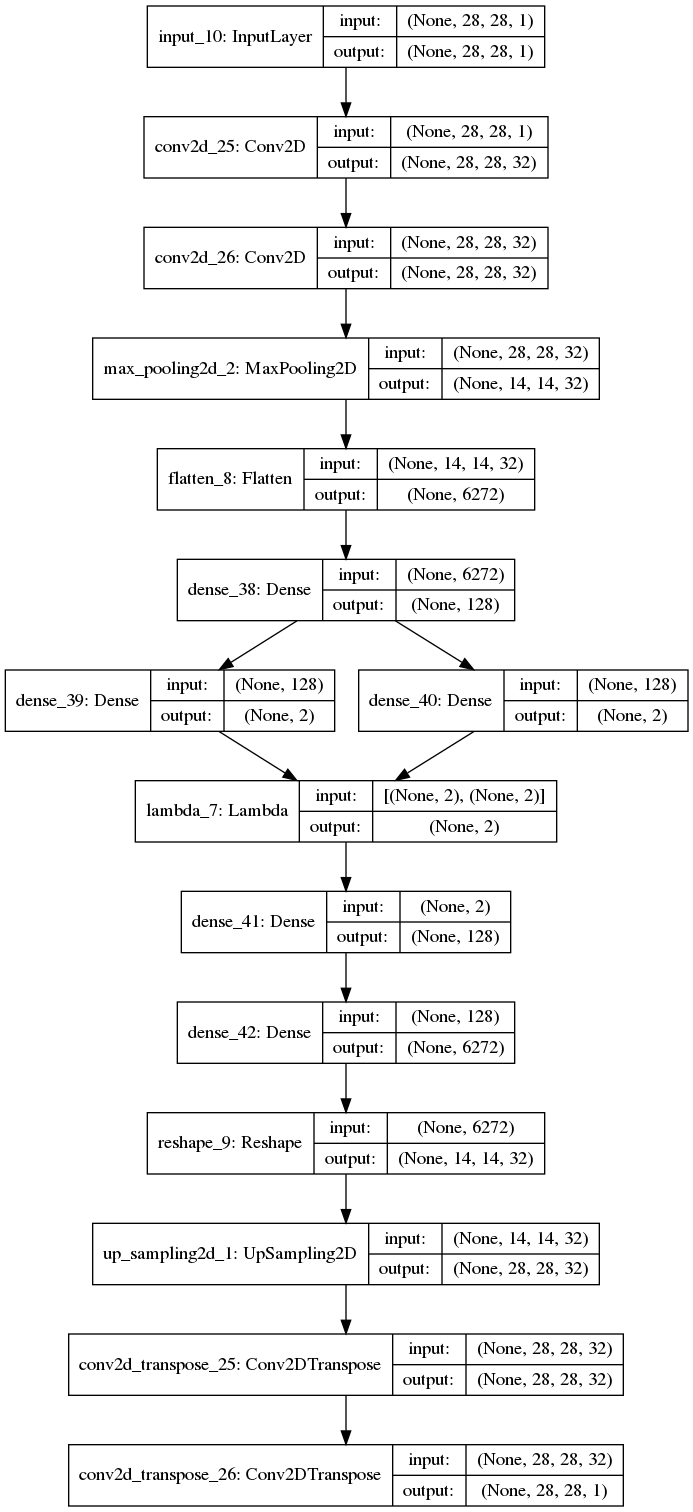

In [79]:
from keras.utils import plot_model
plot_model(vae, to_file='model.png',show_shapes=True)
from IPython.display import Image
Image(filename='model.png')

### Train it

In [379]:
#training params
batch_size = 128 #conv size = 3
epochs = 10
vae.compile(optimizer='rmsprop')
vae.fit(X_train,epochs=epochs, batch_size=batch_size,validation_data=(X_test, None))

/home/casapanshop/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:4: UserWarning: Output "conv2d_transpose_73" missing from loss dictionary. We assume this was done on purpose, and we will not be expecting any data to be passed to "conv2d_transpose_73" during training.
  after removing the cwd from sys.path.


Train on 60000 samples, validate on 10000 samples
Epoch 1/10
60000/60000 [==============================] - 18s 300us/step - loss: 183.4957 - val_loss: 162.5929
Epoch 2/10
60000/60000 [==============================] - 14s 228us/step - loss: 159.4668 - val_loss: 154.4699
Epoch 3/10
60000/60000 [==============================] - 14s 227us/step - loss: 154.0060 - val_loss: 152.6765
Epoch 4/10
60000/60000 [==============================] - 14s 228us/step - loss: 150.7355 - val_loss: 151.0948
Epoch 5/10
60000/60000 [==============================] - 14s 229us/step - loss: 148.5600 - val_loss: 147.8632
Epoch 6/10
60000/60000 [==============================] - 14s 229us/step - loss: 146.8254 - val_loss: 146.0453
Epoch 7/10
60000/60000 [==============================] - 14s 228us/step - loss: 145.4312 - val_loss: 146.7002
Epoch 8/10
60000/60000 [==============================] - 14s 228us/step - loss: 144.2738 - val_loss: 146.4722
Epoch 9/10
60000/60000 [==============================] - 14s 

In [364]:
#training params
batch_size = 128 #con CONV normal al final
epochs = 10 #15 entrenelo durante 10 a 15 epochs?
vae.compile(optimizer='rmsprop')
vae.fit(X_train,epochs=epochs, batch_size=batch_size,validation_data=(X_test, None))

/home/casapanshop/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:4: UserWarning: Output "conv2d_79" missing from loss dictionary. We assume this was done on purpose, and we will not be expecting any data to be passed to "conv2d_79" during training.
  after removing the cwd from sys.path.


Train on 60000 samples, validate on 10000 samples
Epoch 1/10
60000/60000 [==============================] - 15s 248us/step - loss: 190.5521 - val_loss: 164.1878
Epoch 2/10
60000/60000 [==============================] - 11s 184us/step - loss: 160.7552 - val_loss: 157.7915
Epoch 3/10
60000/60000 [==============================] - 11s 184us/step - loss: 155.5314 - val_loss: 154.6408
Epoch 4/10
60000/60000 [==============================] - 11s 184us/step - loss: 152.4774 - val_loss: 151.2148
Epoch 5/10
60000/60000 [==============================] - 11s 184us/step - loss: 150.3334 - val_loss: 149.3216
Epoch 6/10
60000/60000 [==============================] - 11s 184us/step - loss: 148.7449 - val_loss: 148.5133
Epoch 7/10
60000/60000 [==============================] - 11s 184us/step - loss: 147.6509 - val_loss: 147.8082
Epoch 8/10
60000/60000 [==============================] - 11s 184us/step - loss: 146.5227 - val_loss: 146.7830
Epoch 9/10
60000/60000 [==============================] - 11s 

In [171]:
np.mean(x_test_encoded,axis=0)

array([-0.00081157, -0.00047637], dtype=float32)

printee un histograma de la representación "encodeada", por qué es tan cercana a cero?

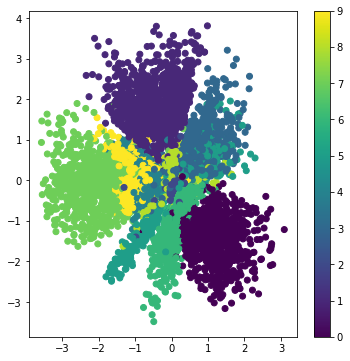

In [380]:
# display a 2D plot of the digit classes in the latent space
x_test_encoded = encoder.predict(X_test, batch_size=batch_size)
import matplotlib.pyplot as plt
%matplotlib inline
plt.figure(figsize=(6, 6))
plt.scatter(x_test_encoded[:, 0], x_test_encoded[:, 1], c=y_test)
plt.colorbar()
plt.show()

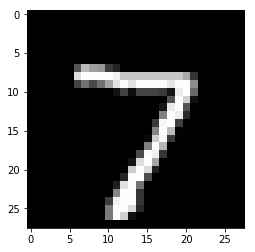

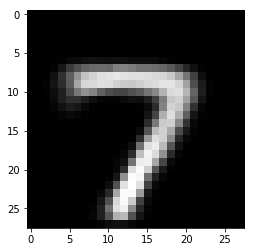

In [381]:
i = 0
reconstructed = vae.predict(X_test[:10])
plt.imshow(X_test[i][:,:,0],cmap='gray')
plt.show()
plt.imshow(reconstructed[i][:,:,0],cmap='gray')
plt.show()

### Test it 

In [11]:
# build a digit generator that can sample from the learned distribution
##NOES NECESARIO SI SE CREA EL MODELO ARRIBA
decoder_input = Input(shape=(latent_dim,))
_hid_decoded = decoder_hid(decoder_input)
_up_decoded = decoder_upsample(_hid_decoded)
_reshape_decoded = decoder_reshape(_up_decoded)
_deconv_1_decoded = decoder_deconv_1(_reshape_decoded)
_x_decoded_relu = decoder_deconv_2(_deconv_1_decoded)
_x_decoded_mean_squash = decoder_mean_squash(_x_decoded_relu)
generator = Model(decoder_input, _x_decoded_mean_squash)

In [12]:
n = 30  # figure with 15x15 images #con mas se ve mas fino
image_size = img_cols
figure = np.zeros((image_size * n, image_size * n))

# linearly spaced coordinates on the unit square were transformed through the inverse CDF (ppf) of the Gaussian
# to produce values of the latent variables z, since the prior of the latent space is Gaussian
from scipy.stats import norm
grid_x = norm.ppf(np.linspace(0.05, 0.95, n))
grid_y = norm.ppf(np.linspace(0.05, 0.95, n))

for i, yi in enumerate(grid_x):
    for j, xi in enumerate(grid_y):
        z_sample = np.array([[xi, yi]])            
        x_decoded = generator.predict(z_sample,batch_size=batch_size)
        figure[i * image_size: (i + 1) * image_size,
               j * image_size: (j + 1) * image_size] = x_decoded[0][:,:,0]
plt.figure(figsize=(10, 10))
plt.imshow(figure,cmap='gnuplot2')
pos = np.arange(image_size/2,image_size*n,image_size)
plt.yticks(pos,np.round(grid_y,1))
plt.xticks(pos,np.round(grid_x,1))
plt.show()

NameError: name 'batch_size' is not defined

In [ ]:
# ver que pasa fuera del intervalo de confianza de 95% en normal
grid_y = norm.ppf(np.linspace(0.000005, 0.999995, n))
[a,b]

## GAN

entender un poco  

un prior en $p_z$

MAX para D la probabilidad que un dato viene de la distribución original de los datos minimizando la probabilidad de que un dato viene de una distribución corrupta  
MAX para G la probabilidad de que D asigne un dato de G como de los datos reales==Min para G la probabilidad de que D asigne un dato de G como corrupto

$$
min_G \ max_G = E_{x\sim p_{data}(x) }[logD(x)] + E_{z\sim p_z(z)}[log(1-D(G(z))]
$$

En el paper muestran qu el óptimo tórico está en $p_g = p_{data}$

El entrenamiento es iterativo, primero D con G fixed, luego G con D fixed, como un minimax game le llaman.

https://oshearesearch.com/wp-content/uploads/2016/07/mnist_gan.png

In [105]:
from keras.models import Model,Sequential
from keras.layers import LeakyReLU,Conv2D,Dropout,Flatten,Dense

## Discriminator
D = Sequential()
depth = 64
dropout = 0.4
# In: 28 x 28 x 1, depth = 1
# Out: 14 x 14 x 1, depth=64
input_shape = (img_rows, img_cols, channel)
D.add(Conv2D(depth*1, (5,5), strides=2, input_shape=input_shape,padding='same', activation=LeakyReLU(alpha=0.2)))
D.add(Dropout(dropout))
D.add(Conv2D(depth*2, (5,5), strides=2, padding='same',activation=LeakyReLU(alpha=0.2)))
D.add(Dropout(dropout))
D.add(Conv2D(depth*4, (5,5), strides=2, padding='same',activation=LeakyReLU(alpha=0.2)))
D.add(Dropout(dropout))
#D.add(Conv2D(depth*8, (5,5), strides=1, padding='same',activation=LeakyReLU(alpha=0.2)))
#D.add(Dropout(dropout))
# Out: 1-dim probability
D.add(Flatten())
D.add(Dense(1024,activation=LeakyReLU(alpha=0.2))) #esto ayuda
#dropa?
D.add(Dense(1,activation='sigmoid'))
D.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_34 (Conv2D)           (None, 14, 14, 64)        1664      
_________________________________________________________________
dropout_34 (Dropout)         (None, 14, 14, 64)        0         
_________________________________________________________________
conv2d_35 (Conv2D)           (None, 7, 7, 128)         204928    
_________________________________________________________________
dropout_35 (Dropout)         (None, 7, 7, 128)         0         
_________________________________________________________________
flatten_12 (Flatten)         (None, 6272)              0         
_________________________________________________________________
dense_43 (Dense)             (None, 1024)              6423552   
_________________________________________________________________
dense_44 (Dense)             (None, 1)                 1025      
Total para

para un buena arquitectura de discriminador... se necesita un muy buen generador

mismo generador de VAE (para comparar)

In [106]:
from keras.layers import BatchNormalization,Reshape,UpSampling2D,Conv2DTranspose,Activation

## Generator
G = Sequential()
dim = 14
input_dim= 2 #para que sea similar al vAE
G.add(Dense(128, input_dim=input_dim))
G.add(BatchNormalization())
G.add(Activation('relu'))

G.add(Dense(dim*dim*depth))
G.add(BatchNormalization())
G.add(Activation('relu'))
G.add(Reshape((dim, dim, depth)))

#G.add(UpSampling2D())
G.add(Conv2DTranspose(depth/2, (3,3), padding='same',strides=(2,2))) #5z5
G.add(BatchNormalization())
G.add(Activation('relu'))

#G.add(UpSampling2D())
G.add(Conv2DTranspose(depth/2, (3,3), padding='same'))
G.add(BatchNormalization())
G.add(Activation('relu'))

#G.add(UpSampling2D())
#G.add(Conv2DTranspose(depth*1, (3,3), padding='same'))
#G.add(BatchNormalization(momentum=0.9))
#G.add(Activation('relu'))
# Out: 28 x 28 x 1 grayscale image [0.0,1.0] per pix
G.add(Conv2DTranspose(channel, (3,3), padding='same'))  # (1x1)?
G.add(Activation('sigmoid')) #puede ser relu?
G.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_45 (Dense)             (None, 128)               384       
_________________________________________________________________
batch_normalization_49 (Batc (None, 128)               512       
_________________________________________________________________
activation_71 (Activation)   (None, 128)               0         
_________________________________________________________________
dense_46 (Dense)             (None, 12544)             1618176   
_________________________________________________________________
batch_normalization_50 (Batc (None, 12544)             50176     
_________________________________________________________________
activation_72 (Activation)   (None, 12544)             0         
_________________________________________________________________
reshape_15 (Reshape)         (None, 14, 14, 64)        0         
__________

In [107]:
from keras.optimizers import RMSprop,Adam
## Discriminator model (police) o directamente ocupar D (no porke se usa en AM)
optimizer = RMSprop(lr=0.0008, clipvalue=1.0, decay=6e-8)
DM = Sequential()
DM.add(D)
DM.compile(loss='binary_crossentropy', optimizer=optimizer,metrics=['accuracy'])

In [108]:
## Adversarial model (Generator->Discriminator)
D.trainable=False #set the discriminator freeze  (fixed params) || antes de compilarlo queda fijo
optimizer = RMSprop(lr=0.0004, clipvalue=1.0, decay=3e-8)
AM = Sequential()
AM.add(G)
AM.add(D)
AM.compile(loss='binary_crossentropy', optimizer=optimizer,metrics=['accuracy'])

In [ ]:
    d_optim = SGD(lr=0.0005, momentum=0.9, nesterov=True)
    g_optim = SGD(lr=0.0005, momentum=0.9, nesterov=True)
    https://www.wouterbulten.nl/blog/tech/getting-started-with-generative-adversarial-networks/

### Train it

In [109]:
train_steps = 5000
batch_size = 64
history = {"d":[],"g":[]}
for e in range(train_steps):
    # Make generative images
    image_batch = X_train[np.random.randint(0,X_train.shape[0],size=batch_size),:,:,:] #sample images from real data
    noise_gen = np.random.uniform(-1,1,size=[batch_size,input_dim]) #sample image from generated data
    generated_images = G.predict(noise_gen) #fake images

    # Train discriminator on generated images
    X = np.concatenate((image_batch, generated_images))
    #create labels
    y = np.ones([2*batch_size,1])
    y[batch_size:,:] = 0
    
    #train discriminator
    #make_trainable(discriminator,True)
    d_loss  = DM.train_on_batch(X,y)
    history["d"].append(d_loss)

    # train Generator-Discriminator stack on input noise to non-generated output class
    noise_tr = np.random.uniform(-1,1,size=[batch_size,input_dim])
    y = np.ones([batch_size, 1])

    #make_trainable(discriminator,False)
    g_loss = AM.train_on_batch(noise_tr, y)
    history["g"].append(g_loss)

    log_mesg = "%d: [D loss: %f, acc: %f]" % (e, d_loss[0], d_loss[1])
    log_mesg = "%s  [G loss: %f, acc: %f]" % (log_mesg, g_loss[0], g_loss[1])
    print(log_mesg)

0: [D loss: 0.684801, acc: 0.625000]  [G loss: 4.937799, acc: 0.000000]
1: [D loss: 0.533028, acc: 0.648438]  [G loss: 0.000003, acc: 1.000000]
2: [D loss: 6.842803, acc: 0.500000]  [G loss: 1.588691, acc: 0.000000]
3: [D loss: 0.423499, acc: 0.828125]  [G loss: 2.045887, acc: 0.000000]
4: [D loss: 0.236509, acc: 0.984375]  [G loss: 1.716469, acc: 0.031250]
5: [D loss: 0.142901, acc: 0.984375]  [G loss: 4.463412, acc: 0.000000]
6: [D loss: 0.234205, acc: 0.882812]  [G loss: 0.076562, acc: 1.000000]
7: [D loss: 1.123254, acc: 0.554688]  [G loss: 3.939084, acc: 0.000000]
8: [D loss: 0.207285, acc: 0.945312]  [G loss: 1.350678, acc: 0.125000]
9: [D loss: 0.129994, acc: 0.968750]  [G loss: 2.498600, acc: 0.000000]
10: [D loss: 0.119038, acc: 0.976562]  [G loss: 1.622865, acc: 0.109375]
11: [D loss: 0.077902, acc: 0.992188]  [G loss: 2.181044, acc: 0.078125]
12: [D loss: 0.101431, acc: 0.984375]  [G loss: 2.966582, acc: 0.000000]
13: [D loss: 0.095394, acc: 1.000000]  [G loss: 0.996850, acc

116: [D loss: 0.561255, acc: 0.671875]  [G loss: 0.850984, acc: 0.328125]
117: [D loss: 0.475278, acc: 0.828125]  [G loss: 0.458249, acc: 0.875000]
118: [D loss: 0.516648, acc: 0.742188]  [G loss: 1.162332, acc: 0.156250]
119: [D loss: 0.517138, acc: 0.742188]  [G loss: 0.248441, acc: 0.984375]
120: [D loss: 0.635467, acc: 0.570312]  [G loss: 1.636796, acc: 0.031250]
121: [D loss: 0.623702, acc: 0.609375]  [G loss: 0.229127, acc: 1.000000]
122: [D loss: 0.678749, acc: 0.562500]  [G loss: 1.111160, acc: 0.078125]
123: [D loss: 0.538589, acc: 0.718750]  [G loss: 0.552767, acc: 0.828125]
124: [D loss: 0.509467, acc: 0.773438]  [G loss: 0.847657, acc: 0.312500]
125: [D loss: 0.533094, acc: 0.750000]  [G loss: 0.547507, acc: 0.765625]
126: [D loss: 0.499050, acc: 0.796875]  [G loss: 1.167704, acc: 0.062500]
127: [D loss: 0.547955, acc: 0.718750]  [G loss: 0.292102, acc: 0.984375]
128: [D loss: 0.745699, acc: 0.539062]  [G loss: 1.918608, acc: 0.000000]
129: [D loss: 0.688328, acc: 0.609375]

228: [D loss: 0.541557, acc: 0.750000]  [G loss: 0.678750, acc: 0.546875]
229: [D loss: 0.521175, acc: 0.726562]  [G loss: 1.027322, acc: 0.156250]
230: [D loss: 0.448561, acc: 0.843750]  [G loss: 0.748535, acc: 0.421875]
231: [D loss: 0.516549, acc: 0.757812]  [G loss: 1.022790, acc: 0.234375]
232: [D loss: 0.504015, acc: 0.781250]  [G loss: 0.837526, acc: 0.375000]
233: [D loss: 0.567805, acc: 0.687500]  [G loss: 1.555856, acc: 0.031250]
234: [D loss: 0.543537, acc: 0.765625]  [G loss: 0.480237, acc: 0.828125]
235: [D loss: 0.623854, acc: 0.593750]  [G loss: 2.024417, acc: 0.000000]
236: [D loss: 0.669410, acc: 0.656250]  [G loss: 0.530718, acc: 0.734375]
237: [D loss: 0.790924, acc: 0.593750]  [G loss: 1.948111, acc: 0.000000]
238: [D loss: 0.564518, acc: 0.695312]  [G loss: 1.001359, acc: 0.234375]
239: [D loss: 0.698797, acc: 0.570312]  [G loss: 1.349258, acc: 0.031250]
240: [D loss: 0.651926, acc: 0.617188]  [G loss: 0.810853, acc: 0.375000]
241: [D loss: 0.580578, acc: 0.695312]

340: [D loss: 0.591946, acc: 0.632812]  [G loss: 1.370480, acc: 0.015625]
341: [D loss: 0.545045, acc: 0.710938]  [G loss: 0.555157, acc: 0.796875]
342: [D loss: 0.586756, acc: 0.640625]  [G loss: 1.097371, acc: 0.078125]
343: [D loss: 0.574017, acc: 0.679688]  [G loss: 0.809814, acc: 0.343750]
344: [D loss: 0.536683, acc: 0.765625]  [G loss: 0.968074, acc: 0.265625]
345: [D loss: 0.619292, acc: 0.671875]  [G loss: 0.693954, acc: 0.531250]
346: [D loss: 0.633583, acc: 0.679688]  [G loss: 1.009392, acc: 0.156250]
347: [D loss: 0.569005, acc: 0.703125]  [G loss: 0.318814, acc: 0.968750]
348: [D loss: 0.654678, acc: 0.570312]  [G loss: 1.236210, acc: 0.125000]
349: [D loss: 0.610282, acc: 0.703125]  [G loss: 0.567992, acc: 0.640625]
350: [D loss: 0.545660, acc: 0.703125]  [G loss: 1.084678, acc: 0.062500]
351: [D loss: 0.554162, acc: 0.679688]  [G loss: 0.608418, acc: 0.687500]
352: [D loss: 0.608668, acc: 0.632812]  [G loss: 1.332636, acc: 0.078125]
353: [D loss: 0.626425, acc: 0.640625]

452: [D loss: 0.657299, acc: 0.617188]  [G loss: 1.537917, acc: 0.015625]
453: [D loss: 0.566980, acc: 0.679688]  [G loss: 0.680278, acc: 0.546875]
454: [D loss: 0.595105, acc: 0.648438]  [G loss: 1.117896, acc: 0.156250]
455: [D loss: 0.439553, acc: 0.820312]  [G loss: 0.765132, acc: 0.484375]
456: [D loss: 0.477537, acc: 0.750000]  [G loss: 0.739234, acc: 0.484375]
457: [D loss: 0.514669, acc: 0.710938]  [G loss: 0.823028, acc: 0.453125]
458: [D loss: 0.562038, acc: 0.718750]  [G loss: 0.936521, acc: 0.234375]
459: [D loss: 0.505371, acc: 0.750000]  [G loss: 0.773378, acc: 0.468750]
460: [D loss: 0.619927, acc: 0.671875]  [G loss: 1.162036, acc: 0.109375]
461: [D loss: 0.508105, acc: 0.695312]  [G loss: 0.244722, acc: 0.953125]
462: [D loss: 0.674824, acc: 0.625000]  [G loss: 1.264708, acc: 0.078125]
463: [D loss: 0.527875, acc: 0.726562]  [G loss: 0.394069, acc: 0.890625]
464: [D loss: 0.571110, acc: 0.710938]  [G loss: 0.672721, acc: 0.578125]
465: [D loss: 0.523314, acc: 0.765625]

564: [D loss: 0.538954, acc: 0.695312]  [G loss: 0.655647, acc: 0.609375]
565: [D loss: 0.524284, acc: 0.703125]  [G loss: 1.120686, acc: 0.203125]
566: [D loss: 0.663614, acc: 0.593750]  [G loss: 1.032565, acc: 0.218750]
567: [D loss: 0.531596, acc: 0.726562]  [G loss: 0.772527, acc: 0.453125]
568: [D loss: 0.461237, acc: 0.796875]  [G loss: 1.372623, acc: 0.203125]
569: [D loss: 0.440806, acc: 0.804688]  [G loss: 0.682967, acc: 0.609375]
570: [D loss: 0.476152, acc: 0.765625]  [G loss: 1.419336, acc: 0.140625]
571: [D loss: 0.513762, acc: 0.703125]  [G loss: 0.279448, acc: 0.906250]
572: [D loss: 0.464537, acc: 0.757812]  [G loss: 1.373877, acc: 0.265625]
573: [D loss: 0.453897, acc: 0.804688]  [G loss: 0.775647, acc: 0.562500]
574: [D loss: 0.414161, acc: 0.828125]  [G loss: 1.277251, acc: 0.156250]
575: [D loss: 0.383460, acc: 0.875000]  [G loss: 0.740046, acc: 0.515625]
576: [D loss: 0.423337, acc: 0.734375]  [G loss: 2.491917, acc: 0.000000]
577: [D loss: 0.470424, acc: 0.765625]

676: [D loss: 0.411339, acc: 0.820312]  [G loss: 0.476308, acc: 0.734375]
677: [D loss: 0.492034, acc: 0.742188]  [G loss: 1.373516, acc: 0.109375]
678: [D loss: 0.582632, acc: 0.640625]  [G loss: 0.499458, acc: 0.765625]
679: [D loss: 0.447402, acc: 0.828125]  [G loss: 1.306120, acc: 0.109375]
680: [D loss: 0.439755, acc: 0.796875]  [G loss: 0.810173, acc: 0.375000]
681: [D loss: 0.615029, acc: 0.601562]  [G loss: 0.928395, acc: 0.421875]
682: [D loss: 0.550683, acc: 0.687500]  [G loss: 0.761019, acc: 0.500000]
683: [D loss: 0.433944, acc: 0.820312]  [G loss: 1.156736, acc: 0.156250]
684: [D loss: 0.449715, acc: 0.757812]  [G loss: 0.424010, acc: 0.843750]
685: [D loss: 0.477893, acc: 0.695312]  [G loss: 2.210641, acc: 0.000000]
686: [D loss: 0.691869, acc: 0.640625]  [G loss: 0.225451, acc: 0.984375]
687: [D loss: 0.653020, acc: 0.664062]  [G loss: 1.359604, acc: 0.218750]
688: [D loss: 0.427233, acc: 0.789062]  [G loss: 0.588800, acc: 0.656250]
689: [D loss: 0.449511, acc: 0.828125]

788: [D loss: 0.488526, acc: 0.726562]  [G loss: 0.231681, acc: 0.984375]
789: [D loss: 0.602345, acc: 0.687500]  [G loss: 1.239438, acc: 0.093750]
790: [D loss: 0.550480, acc: 0.726562]  [G loss: 0.436522, acc: 0.828125]
791: [D loss: 0.457320, acc: 0.796875]  [G loss: 0.725567, acc: 0.531250]
792: [D loss: 0.515118, acc: 0.750000]  [G loss: 0.480975, acc: 0.812500]
793: [D loss: 0.524578, acc: 0.750000]  [G loss: 1.015350, acc: 0.281250]
794: [D loss: 0.504887, acc: 0.734375]  [G loss: 0.290246, acc: 0.890625]
795: [D loss: 0.568415, acc: 0.687500]  [G loss: 1.102265, acc: 0.093750]
796: [D loss: 0.421027, acc: 0.843750]  [G loss: 0.490650, acc: 0.781250]
797: [D loss: 0.575150, acc: 0.640625]  [G loss: 1.390847, acc: 0.093750]
798: [D loss: 0.580867, acc: 0.664062]  [G loss: 0.471694, acc: 0.718750]
799: [D loss: 0.544694, acc: 0.671875]  [G loss: 1.622665, acc: 0.000000]
800: [D loss: 0.429668, acc: 0.789062]  [G loss: 0.628250, acc: 0.578125]
801: [D loss: 0.657090, acc: 0.578125]

900: [D loss: 0.600997, acc: 0.656250]  [G loss: 0.929513, acc: 0.312500]
901: [D loss: 0.400744, acc: 0.843750]  [G loss: 1.091574, acc: 0.265625]
902: [D loss: 0.452686, acc: 0.765625]  [G loss: 0.982214, acc: 0.281250]
903: [D loss: 0.402873, acc: 0.835938]  [G loss: 1.065054, acc: 0.234375]
904: [D loss: 0.420153, acc: 0.835938]  [G loss: 0.904580, acc: 0.375000]
905: [D loss: 0.368174, acc: 0.851562]  [G loss: 1.555281, acc: 0.046875]
906: [D loss: 0.416207, acc: 0.804688]  [G loss: 0.661564, acc: 0.609375]
907: [D loss: 0.499803, acc: 0.671875]  [G loss: 2.006641, acc: 0.000000]
908: [D loss: 0.484575, acc: 0.726562]  [G loss: 0.678512, acc: 0.562500]
909: [D loss: 0.486279, acc: 0.703125]  [G loss: 1.484803, acc: 0.062500]
910: [D loss: 0.344522, acc: 0.867188]  [G loss: 0.983303, acc: 0.250000]
911: [D loss: 0.463216, acc: 0.750000]  [G loss: 1.316179, acc: 0.093750]
912: [D loss: 0.532734, acc: 0.687500]  [G loss: 1.156381, acc: 0.140625]
913: [D loss: 0.604581, acc: 0.679688]

1012: [D loss: 0.513813, acc: 0.742188]  [G loss: 0.503588, acc: 0.703125]
1013: [D loss: 0.595053, acc: 0.640625]  [G loss: 1.634300, acc: 0.109375]
1014: [D loss: 0.589278, acc: 0.734375]  [G loss: 0.499606, acc: 0.718750]
1015: [D loss: 0.417898, acc: 0.796875]  [G loss: 1.069753, acc: 0.328125]
1016: [D loss: 0.445107, acc: 0.796875]  [G loss: 0.719390, acc: 0.484375]
1017: [D loss: 0.435889, acc: 0.789062]  [G loss: 0.863049, acc: 0.484375]
1018: [D loss: 0.490084, acc: 0.750000]  [G loss: 0.857273, acc: 0.421875]
1019: [D loss: 0.421959, acc: 0.789062]  [G loss: 0.840017, acc: 0.437500]
1020: [D loss: 0.408058, acc: 0.804688]  [G loss: 0.535928, acc: 0.718750]
1021: [D loss: 0.408578, acc: 0.812500]  [G loss: 1.673454, acc: 0.093750]
1022: [D loss: 0.453612, acc: 0.812500]  [G loss: 0.373325, acc: 0.859375]
1023: [D loss: 0.643290, acc: 0.640625]  [G loss: 2.374705, acc: 0.000000]
1024: [D loss: 0.627638, acc: 0.656250]  [G loss: 0.383860, acc: 0.921875]
1025: [D loss: 0.606314, 

1124: [D loss: 0.514005, acc: 0.757812]  [G loss: 1.077323, acc: 0.265625]
1125: [D loss: 0.400477, acc: 0.835938]  [G loss: 0.797122, acc: 0.500000]
1126: [D loss: 0.350174, acc: 0.875000]  [G loss: 1.464966, acc: 0.187500]
1127: [D loss: 0.325954, acc: 0.867188]  [G loss: 0.538912, acc: 0.625000]
1128: [D loss: 0.385950, acc: 0.812500]  [G loss: 1.337634, acc: 0.250000]
1129: [D loss: 0.480027, acc: 0.773438]  [G loss: 0.534733, acc: 0.656250]
1130: [D loss: 0.386030, acc: 0.828125]  [G loss: 1.660857, acc: 0.078125]
1131: [D loss: 0.499917, acc: 0.750000]  [G loss: 0.464396, acc: 0.781250]
1132: [D loss: 0.578649, acc: 0.726562]  [G loss: 1.720454, acc: 0.078125]
1133: [D loss: 0.370529, acc: 0.843750]  [G loss: 0.808492, acc: 0.515625]
1134: [D loss: 0.352663, acc: 0.828125]  [G loss: 1.132093, acc: 0.328125]
1135: [D loss: 0.392464, acc: 0.843750]  [G loss: 0.563256, acc: 0.640625]
1136: [D loss: 0.366086, acc: 0.828125]  [G loss: 1.192204, acc: 0.281250]
1137: [D loss: 0.367914, 

1236: [D loss: 0.400636, acc: 0.781250]  [G loss: 0.965890, acc: 0.359375]
1237: [D loss: 0.479075, acc: 0.734375]  [G loss: 1.193255, acc: 0.265625]
1238: [D loss: 0.415332, acc: 0.812500]  [G loss: 0.471130, acc: 0.781250]
1239: [D loss: 0.388253, acc: 0.812500]  [G loss: 0.569872, acc: 0.656250]
1240: [D loss: 0.455975, acc: 0.789062]  [G loss: 1.185724, acc: 0.171875]
1241: [D loss: 0.382918, acc: 0.812500]  [G loss: 0.595853, acc: 0.703125]
1242: [D loss: 0.420401, acc: 0.765625]  [G loss: 1.764632, acc: 0.093750]
1243: [D loss: 0.488751, acc: 0.750000]  [G loss: 0.391526, acc: 0.859375]
1244: [D loss: 0.633543, acc: 0.664062]  [G loss: 1.542130, acc: 0.046875]
1245: [D loss: 0.505670, acc: 0.695312]  [G loss: 0.708263, acc: 0.484375]
1246: [D loss: 0.391873, acc: 0.812500]  [G loss: 0.998580, acc: 0.296875]
1247: [D loss: 0.439563, acc: 0.820312]  [G loss: 0.908629, acc: 0.359375]
1248: [D loss: 0.404457, acc: 0.804688]  [G loss: 1.052516, acc: 0.328125]
1249: [D loss: 0.443979, 

1348: [D loss: 0.345208, acc: 0.843750]  [G loss: 0.529040, acc: 0.718750]
1349: [D loss: 0.526626, acc: 0.718750]  [G loss: 2.831857, acc: 0.000000]
1350: [D loss: 0.444607, acc: 0.750000]  [G loss: 1.230630, acc: 0.250000]
1351: [D loss: 0.356839, acc: 0.843750]  [G loss: 1.441229, acc: 0.140625]
1352: [D loss: 0.267817, acc: 0.898438]  [G loss: 1.200477, acc: 0.265625]
1353: [D loss: 0.303482, acc: 0.859375]  [G loss: 1.590423, acc: 0.078125]
1354: [D loss: 0.363173, acc: 0.835938]  [G loss: 0.887927, acc: 0.359375]
1355: [D loss: 0.470405, acc: 0.812500]  [G loss: 1.749588, acc: 0.187500]
1356: [D loss: 0.446014, acc: 0.804688]  [G loss: 1.193027, acc: 0.281250]
1357: [D loss: 0.447024, acc: 0.742188]  [G loss: 2.093066, acc: 0.125000]
1358: [D loss: 0.374726, acc: 0.796875]  [G loss: 1.203341, acc: 0.250000]
1359: [D loss: 0.381872, acc: 0.796875]  [G loss: 1.490826, acc: 0.125000]
1360: [D loss: 0.337000, acc: 0.859375]  [G loss: 1.582482, acc: 0.046875]
1361: [D loss: 0.391065, 

1460: [D loss: 0.308201, acc: 0.875000]  [G loss: 0.725164, acc: 0.484375]
1461: [D loss: 0.292401, acc: 0.882812]  [G loss: 0.908353, acc: 0.453125]
1462: [D loss: 0.308784, acc: 0.851562]  [G loss: 0.370572, acc: 0.843750]
1463: [D loss: 0.462596, acc: 0.796875]  [G loss: 1.700062, acc: 0.171875]
1464: [D loss: 0.443013, acc: 0.796875]  [G loss: 0.585607, acc: 0.640625]
1465: [D loss: 0.413117, acc: 0.804688]  [G loss: 1.424098, acc: 0.171875]
1466: [D loss: 0.322849, acc: 0.867188]  [G loss: 0.608286, acc: 0.656250]
1467: [D loss: 0.469627, acc: 0.734375]  [G loss: 1.719273, acc: 0.125000]
1468: [D loss: 0.515952, acc: 0.773438]  [G loss: 0.550875, acc: 0.703125]
1469: [D loss: 0.562708, acc: 0.687500]  [G loss: 1.691782, acc: 0.093750]
1470: [D loss: 0.495523, acc: 0.734375]  [G loss: 1.010214, acc: 0.281250]
1471: [D loss: 0.385706, acc: 0.812500]  [G loss: 0.892249, acc: 0.375000]
1472: [D loss: 0.394082, acc: 0.835938]  [G loss: 0.672502, acc: 0.578125]
1473: [D loss: 0.373349, 

1572: [D loss: 0.328583, acc: 0.835938]  [G loss: 0.563795, acc: 0.734375]
1573: [D loss: 0.509620, acc: 0.726562]  [G loss: 1.444437, acc: 0.156250]
1574: [D loss: 0.383818, acc: 0.843750]  [G loss: 0.564321, acc: 0.671875]
1575: [D loss: 0.449056, acc: 0.781250]  [G loss: 1.193647, acc: 0.265625]
1576: [D loss: 0.498761, acc: 0.734375]  [G loss: 0.825518, acc: 0.453125]
1577: [D loss: 0.406425, acc: 0.796875]  [G loss: 1.402944, acc: 0.125000]
1578: [D loss: 0.360437, acc: 0.804688]  [G loss: 0.884291, acc: 0.468750]
1579: [D loss: 0.352728, acc: 0.820312]  [G loss: 0.694412, acc: 0.640625]
1580: [D loss: 0.334607, acc: 0.828125]  [G loss: 1.413284, acc: 0.187500]
1581: [D loss: 0.369903, acc: 0.851562]  [G loss: 0.862830, acc: 0.468750]
1582: [D loss: 0.337934, acc: 0.851562]  [G loss: 1.094625, acc: 0.390625]
1583: [D loss: 0.360854, acc: 0.820312]  [G loss: 1.336543, acc: 0.140625]
1584: [D loss: 0.280280, acc: 0.906250]  [G loss: 0.632763, acc: 0.750000]
1585: [D loss: 0.333175, 

1684: [D loss: 0.313452, acc: 0.835938]  [G loss: 0.419914, acc: 0.828125]
1685: [D loss: 0.672649, acc: 0.656250]  [G loss: 2.102236, acc: 0.062500]
1686: [D loss: 0.560057, acc: 0.726562]  [G loss: 0.583933, acc: 0.671875]
1687: [D loss: 0.360560, acc: 0.843750]  [G loss: 1.225923, acc: 0.218750]
1688: [D loss: 0.366788, acc: 0.828125]  [G loss: 1.494851, acc: 0.156250]
1689: [D loss: 0.331491, acc: 0.875000]  [G loss: 0.895995, acc: 0.437500]
1690: [D loss: 0.302297, acc: 0.835938]  [G loss: 1.512396, acc: 0.109375]
1691: [D loss: 0.406890, acc: 0.812500]  [G loss: 0.480156, acc: 0.781250]
1692: [D loss: 0.320292, acc: 0.828125]  [G loss: 1.429019, acc: 0.187500]
1693: [D loss: 0.394490, acc: 0.812500]  [G loss: 1.094711, acc: 0.296875]
1694: [D loss: 0.289970, acc: 0.851562]  [G loss: 0.940383, acc: 0.437500]
1695: [D loss: 0.463314, acc: 0.773438]  [G loss: 1.205906, acc: 0.312500]
1696: [D loss: 0.428616, acc: 0.781250]  [G loss: 1.210742, acc: 0.359375]
1697: [D loss: 0.303290, 

1796: [D loss: 0.340268, acc: 0.851562]  [G loss: 1.216520, acc: 0.359375]
1797: [D loss: 0.358915, acc: 0.835938]  [G loss: 0.531243, acc: 0.750000]
1798: [D loss: 0.546423, acc: 0.679688]  [G loss: 2.696654, acc: 0.015625]
1799: [D loss: 0.655659, acc: 0.703125]  [G loss: 0.274531, acc: 0.906250]
1800: [D loss: 0.633343, acc: 0.671875]  [G loss: 1.133167, acc: 0.421875]
1801: [D loss: 0.445307, acc: 0.804688]  [G loss: 1.051332, acc: 0.359375]
1802: [D loss: 0.236338, acc: 0.914062]  [G loss: 0.497943, acc: 0.796875]
1803: [D loss: 0.291984, acc: 0.859375]  [G loss: 0.661804, acc: 0.687500]
1804: [D loss: 0.384282, acc: 0.789062]  [G loss: 0.593530, acc: 0.625000]
1805: [D loss: 0.345999, acc: 0.789062]  [G loss: 0.853128, acc: 0.593750]
1806: [D loss: 0.467803, acc: 0.812500]  [G loss: 1.220574, acc: 0.281250]
1807: [D loss: 0.515926, acc: 0.773438]  [G loss: 1.096293, acc: 0.359375]
1808: [D loss: 0.416203, acc: 0.812500]  [G loss: 0.736512, acc: 0.468750]
1809: [D loss: 0.461789, 

1908: [D loss: 0.499585, acc: 0.773438]  [G loss: 0.422581, acc: 0.796875]
1909: [D loss: 0.641927, acc: 0.710938]  [G loss: 1.863618, acc: 0.250000]
1910: [D loss: 0.436690, acc: 0.812500]  [G loss: 1.274122, acc: 0.265625]
1911: [D loss: 0.608916, acc: 0.710938]  [G loss: 0.956645, acc: 0.421875]
1912: [D loss: 0.389550, acc: 0.804688]  [G loss: 0.819996, acc: 0.484375]
1913: [D loss: 0.411016, acc: 0.773438]  [G loss: 1.443909, acc: 0.265625]
1914: [D loss: 0.439902, acc: 0.796875]  [G loss: 0.805853, acc: 0.500000]
1915: [D loss: 0.345413, acc: 0.859375]  [G loss: 0.696949, acc: 0.609375]
1916: [D loss: 0.359985, acc: 0.828125]  [G loss: 1.384041, acc: 0.265625]
1917: [D loss: 0.339776, acc: 0.820312]  [G loss: 0.580248, acc: 0.671875]
1918: [D loss: 0.498278, acc: 0.734375]  [G loss: 2.362717, acc: 0.000000]
1919: [D loss: 0.700485, acc: 0.695312]  [G loss: 0.561685, acc: 0.703125]
1920: [D loss: 0.424914, acc: 0.765625]  [G loss: 1.279615, acc: 0.296875]
1921: [D loss: 0.396429, 

2020: [D loss: 0.572086, acc: 0.718750]  [G loss: 1.779739, acc: 0.218750]
2021: [D loss: 0.436114, acc: 0.804688]  [G loss: 0.647536, acc: 0.656250]
2022: [D loss: 0.472427, acc: 0.765625]  [G loss: 0.839672, acc: 0.546875]
2023: [D loss: 0.369123, acc: 0.867188]  [G loss: 0.555487, acc: 0.687500]
2024: [D loss: 0.356077, acc: 0.851562]  [G loss: 0.780202, acc: 0.609375]
2025: [D loss: 0.483529, acc: 0.734375]  [G loss: 1.209579, acc: 0.312500]
2026: [D loss: 0.487506, acc: 0.789062]  [G loss: 0.638533, acc: 0.578125]
2027: [D loss: 0.434627, acc: 0.773438]  [G loss: 1.016531, acc: 0.359375]
2028: [D loss: 0.499809, acc: 0.765625]  [G loss: 0.809255, acc: 0.484375]
2029: [D loss: 0.431454, acc: 0.804688]  [G loss: 0.944652, acc: 0.421875]
2030: [D loss: 0.343751, acc: 0.914062]  [G loss: 0.433294, acc: 0.765625]
2031: [D loss: 0.481717, acc: 0.765625]  [G loss: 1.417620, acc: 0.312500]
2032: [D loss: 0.464982, acc: 0.781250]  [G loss: 0.260713, acc: 0.953125]
2033: [D loss: 0.584240, 

2132: [D loss: 0.420773, acc: 0.796875]  [G loss: 2.308964, acc: 0.046875]
2133: [D loss: 0.398939, acc: 0.812500]  [G loss: 1.008807, acc: 0.312500]
2134: [D loss: 0.288958, acc: 0.859375]  [G loss: 1.940990, acc: 0.062500]
2135: [D loss: 0.227615, acc: 0.906250]  [G loss: 0.995394, acc: 0.359375]
2136: [D loss: 0.139975, acc: 0.960938]  [G loss: 0.592887, acc: 0.640625]
2137: [D loss: 0.450672, acc: 0.765625]  [G loss: 2.118320, acc: 0.062500]
2138: [D loss: 0.405000, acc: 0.828125]  [G loss: 0.747932, acc: 0.531250]
2139: [D loss: 0.426581, acc: 0.781250]  [G loss: 1.352244, acc: 0.343750]
2140: [D loss: 0.309557, acc: 0.875000]  [G loss: 0.567722, acc: 0.687500]
2141: [D loss: 0.618896, acc: 0.750000]  [G loss: 1.915589, acc: 0.109375]
2142: [D loss: 0.399834, acc: 0.812500]  [G loss: 0.752713, acc: 0.531250]
2143: [D loss: 0.461069, acc: 0.789062]  [G loss: 1.481621, acc: 0.250000]
2144: [D loss: 0.563264, acc: 0.726562]  [G loss: 0.646456, acc: 0.671875]
2145: [D loss: 0.494337, 

2244: [D loss: 0.369106, acc: 0.820312]  [G loss: 0.939287, acc: 0.500000]
2245: [D loss: 0.252234, acc: 0.914062]  [G loss: 1.523035, acc: 0.203125]
2246: [D loss: 0.449992, acc: 0.781250]  [G loss: 0.270926, acc: 0.921875]
2247: [D loss: 0.495669, acc: 0.742188]  [G loss: 1.709555, acc: 0.171875]
2248: [D loss: 0.284045, acc: 0.890625]  [G loss: 0.754148, acc: 0.546875]
2249: [D loss: 0.328062, acc: 0.843750]  [G loss: 1.093467, acc: 0.359375]
2250: [D loss: 0.371122, acc: 0.804688]  [G loss: 1.625406, acc: 0.218750]
2251: [D loss: 0.318929, acc: 0.890625]  [G loss: 0.755407, acc: 0.546875]
2252: [D loss: 0.315931, acc: 0.820312]  [G loss: 1.551661, acc: 0.203125]
2253: [D loss: 0.243982, acc: 0.882812]  [G loss: 1.056013, acc: 0.343750]
2254: [D loss: 0.399981, acc: 0.765625]  [G loss: 2.026677, acc: 0.109375]
2255: [D loss: 0.391949, acc: 0.812500]  [G loss: 1.211114, acc: 0.375000]
2256: [D loss: 0.383297, acc: 0.812500]  [G loss: 2.498555, acc: 0.015625]
2257: [D loss: 0.547215, 

2356: [D loss: 0.340823, acc: 0.875000]  [G loss: 0.948920, acc: 0.328125]
2357: [D loss: 0.424632, acc: 0.773438]  [G loss: 0.782253, acc: 0.484375]
2358: [D loss: 0.430920, acc: 0.781250]  [G loss: 1.152712, acc: 0.281250]
2359: [D loss: 0.285133, acc: 0.890625]  [G loss: 0.883135, acc: 0.484375]
2360: [D loss: 0.310409, acc: 0.851562]  [G loss: 1.212441, acc: 0.312500]
2361: [D loss: 0.438897, acc: 0.781250]  [G loss: 0.292673, acc: 0.828125]
2362: [D loss: 0.540415, acc: 0.734375]  [G loss: 1.551039, acc: 0.296875]
2363: [D loss: 0.467726, acc: 0.789062]  [G loss: 0.526554, acc: 0.718750]
2364: [D loss: 0.575493, acc: 0.703125]  [G loss: 1.445399, acc: 0.218750]
2365: [D loss: 0.382152, acc: 0.812500]  [G loss: 0.814309, acc: 0.437500]
2366: [D loss: 0.457359, acc: 0.726562]  [G loss: 1.226536, acc: 0.281250]
2367: [D loss: 0.537062, acc: 0.757812]  [G loss: 0.744085, acc: 0.593750]
2368: [D loss: 0.441615, acc: 0.789062]  [G loss: 0.780887, acc: 0.500000]
2369: [D loss: 0.354371, 

2468: [D loss: 0.298625, acc: 0.867188]  [G loss: 2.032358, acc: 0.125000]
2469: [D loss: 0.238077, acc: 0.921875]  [G loss: 1.462860, acc: 0.250000]
2470: [D loss: 0.389997, acc: 0.804688]  [G loss: 2.089952, acc: 0.140625]
2471: [D loss: 0.339905, acc: 0.828125]  [G loss: 0.974506, acc: 0.656250]
2472: [D loss: 0.322772, acc: 0.851562]  [G loss: 2.660589, acc: 0.015625]
2473: [D loss: 0.372627, acc: 0.828125]  [G loss: 0.500295, acc: 0.750000]
2474: [D loss: 0.467490, acc: 0.773438]  [G loss: 2.682631, acc: 0.078125]
2475: [D loss: 0.464111, acc: 0.773438]  [G loss: 0.486090, acc: 0.734375]
2476: [D loss: 0.390513, acc: 0.804688]  [G loss: 1.410082, acc: 0.281250]
2477: [D loss: 0.345645, acc: 0.828125]  [G loss: 0.792508, acc: 0.578125]
2478: [D loss: 0.362342, acc: 0.843750]  [G loss: 1.545416, acc: 0.218750]
2479: [D loss: 0.346805, acc: 0.835938]  [G loss: 0.440697, acc: 0.796875]
2480: [D loss: 0.301955, acc: 0.859375]  [G loss: 1.526672, acc: 0.265625]
2481: [D loss: 0.273299, 

2580: [D loss: 0.254042, acc: 0.906250]  [G loss: 0.716027, acc: 0.640625]
2581: [D loss: 0.361441, acc: 0.835938]  [G loss: 2.510813, acc: 0.078125]
2582: [D loss: 0.566714, acc: 0.765625]  [G loss: 0.324788, acc: 0.890625]
2583: [D loss: 0.461990, acc: 0.757812]  [G loss: 1.529517, acc: 0.140625]
2584: [D loss: 0.343092, acc: 0.859375]  [G loss: 0.992756, acc: 0.453125]
2585: [D loss: 0.303069, acc: 0.882812]  [G loss: 1.127107, acc: 0.359375]
2586: [D loss: 0.270524, acc: 0.875000]  [G loss: 0.994667, acc: 0.406250]
2587: [D loss: 0.352871, acc: 0.796875]  [G loss: 0.991117, acc: 0.468750]
2588: [D loss: 0.305374, acc: 0.859375]  [G loss: 1.345783, acc: 0.343750]
2589: [D loss: 0.301864, acc: 0.859375]  [G loss: 0.555199, acc: 0.640625]
2590: [D loss: 0.291523, acc: 0.875000]  [G loss: 1.286052, acc: 0.265625]
2591: [D loss: 0.314668, acc: 0.843750]  [G loss: 0.431476, acc: 0.765625]
2592: [D loss: 0.338663, acc: 0.820312]  [G loss: 1.539989, acc: 0.171875]
2593: [D loss: 0.296439, 

2692: [D loss: 0.353309, acc: 0.835938]  [G loss: 1.413295, acc: 0.203125]
2693: [D loss: 0.297192, acc: 0.890625]  [G loss: 1.048672, acc: 0.484375]
2694: [D loss: 0.355447, acc: 0.867188]  [G loss: 1.206341, acc: 0.421875]
2695: [D loss: 0.308763, acc: 0.867188]  [G loss: 0.485239, acc: 0.750000]
2696: [D loss: 0.459238, acc: 0.750000]  [G loss: 1.943206, acc: 0.234375]
2697: [D loss: 0.486015, acc: 0.773438]  [G loss: 0.454212, acc: 0.750000]
2698: [D loss: 0.372697, acc: 0.796875]  [G loss: 1.315654, acc: 0.328125]
2699: [D loss: 0.237861, acc: 0.898438]  [G loss: 1.033195, acc: 0.359375]
2700: [D loss: 0.292873, acc: 0.859375]  [G loss: 0.867462, acc: 0.484375]
2701: [D loss: 0.298177, acc: 0.875000]  [G loss: 0.955884, acc: 0.468750]
2702: [D loss: 0.345351, acc: 0.843750]  [G loss: 0.697624, acc: 0.578125]
2703: [D loss: 0.481426, acc: 0.757812]  [G loss: 2.880689, acc: 0.046875]
2704: [D loss: 0.556434, acc: 0.734375]  [G loss: 0.399391, acc: 0.734375]
2705: [D loss: 0.434018, 

2804: [D loss: 0.354733, acc: 0.789062]  [G loss: 1.650816, acc: 0.265625]
2805: [D loss: 0.442235, acc: 0.765625]  [G loss: 0.310883, acc: 0.875000]
2806: [D loss: 0.661656, acc: 0.734375]  [G loss: 2.197573, acc: 0.109375]
2807: [D loss: 0.504734, acc: 0.726562]  [G loss: 0.895465, acc: 0.484375]
2808: [D loss: 0.294481, acc: 0.859375]  [G loss: 1.540702, acc: 0.328125]
2809: [D loss: 0.289396, acc: 0.875000]  [G loss: 0.519795, acc: 0.703125]
2810: [D loss: 0.387303, acc: 0.804688]  [G loss: 1.032479, acc: 0.406250]
2811: [D loss: 0.381101, acc: 0.820312]  [G loss: 0.809013, acc: 0.515625]
2812: [D loss: 0.316500, acc: 0.867188]  [G loss: 0.933095, acc: 0.562500]
2813: [D loss: 0.304269, acc: 0.890625]  [G loss: 1.386275, acc: 0.359375]
2814: [D loss: 0.389191, acc: 0.812500]  [G loss: 1.400017, acc: 0.421875]
2815: [D loss: 0.281081, acc: 0.843750]  [G loss: 0.359388, acc: 0.750000]
2816: [D loss: 0.420747, acc: 0.781250]  [G loss: 2.243199, acc: 0.000000]
2817: [D loss: 0.390646, 

2916: [D loss: 0.416497, acc: 0.796875]  [G loss: 1.264862, acc: 0.359375]
2917: [D loss: 0.474937, acc: 0.781250]  [G loss: 0.217141, acc: 0.921875]
2918: [D loss: 0.513617, acc: 0.781250]  [G loss: 1.382699, acc: 0.234375]
2919: [D loss: 0.350234, acc: 0.812500]  [G loss: 0.389280, acc: 0.796875]
2920: [D loss: 0.307788, acc: 0.851562]  [G loss: 0.787908, acc: 0.500000]
2921: [D loss: 0.411833, acc: 0.789062]  [G loss: 0.490764, acc: 0.671875]
2922: [D loss: 0.368348, acc: 0.804688]  [G loss: 1.038437, acc: 0.359375]
2923: [D loss: 0.278489, acc: 0.875000]  [G loss: 0.747721, acc: 0.640625]
2924: [D loss: 0.308934, acc: 0.867188]  [G loss: 1.188138, acc: 0.312500]
2925: [D loss: 0.305519, acc: 0.898438]  [G loss: 0.681967, acc: 0.718750]
2926: [D loss: 0.382589, acc: 0.804688]  [G loss: 1.121414, acc: 0.281250]
2927: [D loss: 0.309787, acc: 0.867188]  [G loss: 0.343999, acc: 0.859375]
2928: [D loss: 0.369670, acc: 0.812500]  [G loss: 1.143299, acc: 0.359375]
2929: [D loss: 0.334466, 

3028: [D loss: 0.521142, acc: 0.796875]  [G loss: 0.144077, acc: 0.968750]
3029: [D loss: 0.505891, acc: 0.765625]  [G loss: 1.359244, acc: 0.359375]
3030: [D loss: 0.275725, acc: 0.867188]  [G loss: 0.632688, acc: 0.656250]
3031: [D loss: 0.323014, acc: 0.820312]  [G loss: 1.433754, acc: 0.265625]
3032: [D loss: 0.332533, acc: 0.851562]  [G loss: 0.477167, acc: 0.703125]
3033: [D loss: 0.457407, acc: 0.789062]  [G loss: 1.464328, acc: 0.281250]
3034: [D loss: 0.395033, acc: 0.812500]  [G loss: 0.486974, acc: 0.765625]
3035: [D loss: 0.427267, acc: 0.820312]  [G loss: 2.073908, acc: 0.046875]
3036: [D loss: 0.432969, acc: 0.828125]  [G loss: 0.426076, acc: 0.828125]
3037: [D loss: 0.445346, acc: 0.757812]  [G loss: 1.938868, acc: 0.125000]
3038: [D loss: 0.287228, acc: 0.898438]  [G loss: 0.607067, acc: 0.609375]
3039: [D loss: 0.258820, acc: 0.882812]  [G loss: 0.436559, acc: 0.765625]
3040: [D loss: 0.349691, acc: 0.828125]  [G loss: 1.218614, acc: 0.218750]
3041: [D loss: 0.329370, 

3140: [D loss: 0.209321, acc: 0.906250]  [G loss: 0.495013, acc: 0.734375]
3141: [D loss: 0.235107, acc: 0.890625]  [G loss: 0.992510, acc: 0.437500]
3142: [D loss: 0.197126, acc: 0.937500]  [G loss: 0.552299, acc: 0.671875]
3143: [D loss: 0.407137, acc: 0.843750]  [G loss: 1.465918, acc: 0.328125]
3144: [D loss: 0.407211, acc: 0.867188]  [G loss: 0.304207, acc: 0.875000]
3145: [D loss: 0.443965, acc: 0.757812]  [G loss: 1.938971, acc: 0.140625]
3146: [D loss: 0.392297, acc: 0.828125]  [G loss: 0.418133, acc: 0.765625]
3147: [D loss: 0.475203, acc: 0.773438]  [G loss: 2.084156, acc: 0.171875]
3148: [D loss: 0.324532, acc: 0.828125]  [G loss: 0.603230, acc: 0.687500]
3149: [D loss: 0.277818, acc: 0.851562]  [G loss: 1.654599, acc: 0.312500]
3150: [D loss: 0.563869, acc: 0.710938]  [G loss: 1.757993, acc: 0.140625]
3151: [D loss: 0.460598, acc: 0.789062]  [G loss: 0.679528, acc: 0.593750]
3152: [D loss: 0.428408, acc: 0.828125]  [G loss: 1.713555, acc: 0.187500]
3153: [D loss: 0.302202, 

3252: [D loss: 0.220158, acc: 0.898438]  [G loss: 1.628553, acc: 0.093750]
3253: [D loss: 0.278177, acc: 0.867188]  [G loss: 0.840359, acc: 0.546875]
3254: [D loss: 0.200224, acc: 0.929688]  [G loss: 0.978315, acc: 0.546875]
3255: [D loss: 0.381175, acc: 0.835938]  [G loss: 1.492619, acc: 0.203125]
3256: [D loss: 0.310055, acc: 0.859375]  [G loss: 0.369027, acc: 0.890625]
3257: [D loss: 0.515452, acc: 0.765625]  [G loss: 3.005370, acc: 0.078125]
3258: [D loss: 0.444882, acc: 0.804688]  [G loss: 0.583934, acc: 0.734375]
3259: [D loss: 0.221705, acc: 0.906250]  [G loss: 0.709953, acc: 0.578125]
3260: [D loss: 0.359450, acc: 0.851562]  [G loss: 0.710027, acc: 0.546875]
3261: [D loss: 0.279371, acc: 0.906250]  [G loss: 0.858713, acc: 0.484375]
3262: [D loss: 0.244730, acc: 0.898438]  [G loss: 0.403794, acc: 0.828125]
3263: [D loss: 0.249615, acc: 0.882812]  [G loss: 1.421268, acc: 0.281250]
3264: [D loss: 0.353040, acc: 0.828125]  [G loss: 0.255220, acc: 0.921875]
3265: [D loss: 0.264874, 

3364: [D loss: 0.287847, acc: 0.828125]  [G loss: 1.004864, acc: 0.437500]
3365: [D loss: 0.222004, acc: 0.898438]  [G loss: 1.167642, acc: 0.312500]
3366: [D loss: 0.235623, acc: 0.875000]  [G loss: 1.429791, acc: 0.328125]
3367: [D loss: 0.212748, acc: 0.929688]  [G loss: 0.899531, acc: 0.562500]
3368: [D loss: 0.262507, acc: 0.859375]  [G loss: 1.347497, acc: 0.406250]
3369: [D loss: 0.318534, acc: 0.851562]  [G loss: 0.528389, acc: 0.781250]
3370: [D loss: 0.396374, acc: 0.789062]  [G loss: 2.072281, acc: 0.156250]
3371: [D loss: 0.331120, acc: 0.867188]  [G loss: 0.563177, acc: 0.703125]
3372: [D loss: 0.381281, acc: 0.851562]  [G loss: 1.434915, acc: 0.406250]
3373: [D loss: 0.339557, acc: 0.867188]  [G loss: 0.539574, acc: 0.703125]
3374: [D loss: 0.345293, acc: 0.859375]  [G loss: 1.672497, acc: 0.109375]
3375: [D loss: 0.230275, acc: 0.906250]  [G loss: 0.749317, acc: 0.609375]
3376: [D loss: 0.193645, acc: 0.937500]  [G loss: 1.386618, acc: 0.375000]
3377: [D loss: 0.190832, 

3476: [D loss: 0.251262, acc: 0.898438]  [G loss: 0.629927, acc: 0.625000]
3477: [D loss: 0.291103, acc: 0.898438]  [G loss: 0.841123, acc: 0.515625]
3478: [D loss: 0.282103, acc: 0.890625]  [G loss: 1.259816, acc: 0.484375]
3479: [D loss: 0.180647, acc: 0.906250]  [G loss: 0.410081, acc: 0.812500]
3480: [D loss: 0.499080, acc: 0.835938]  [G loss: 2.704128, acc: 0.156250]
3481: [D loss: 0.487453, acc: 0.773438]  [G loss: 0.178436, acc: 0.921875]
3482: [D loss: 1.201972, acc: 0.664062]  [G loss: 2.703237, acc: 0.171875]
3483: [D loss: 0.453488, acc: 0.789062]  [G loss: 0.667414, acc: 0.656250]
3484: [D loss: 0.438643, acc: 0.843750]  [G loss: 0.770226, acc: 0.609375]
3485: [D loss: 0.274435, acc: 0.882812]  [G loss: 0.820872, acc: 0.578125]
3486: [D loss: 0.314289, acc: 0.843750]  [G loss: 0.693881, acc: 0.656250]
3487: [D loss: 0.335802, acc: 0.890625]  [G loss: 0.518561, acc: 0.781250]
3488: [D loss: 0.298551, acc: 0.859375]  [G loss: 1.097864, acc: 0.515625]
3489: [D loss: 0.208214, 

3588: [D loss: 0.270758, acc: 0.898438]  [G loss: 0.381834, acc: 0.812500]
3589: [D loss: 0.308247, acc: 0.875000]  [G loss: 1.003062, acc: 0.531250]
3590: [D loss: 0.237509, acc: 0.890625]  [G loss: 0.622050, acc: 0.640625]
3591: [D loss: 0.337981, acc: 0.828125]  [G loss: 0.832969, acc: 0.562500]
3592: [D loss: 0.231707, acc: 0.898438]  [G loss: 0.306385, acc: 0.828125]
3593: [D loss: 0.282775, acc: 0.882812]  [G loss: 0.759622, acc: 0.625000]
3594: [D loss: 0.272039, acc: 0.882812]  [G loss: 0.384774, acc: 0.843750]
3595: [D loss: 0.279632, acc: 0.867188]  [G loss: 0.878322, acc: 0.593750]
3596: [D loss: 0.263623, acc: 0.867188]  [G loss: 0.605026, acc: 0.687500]
3597: [D loss: 0.231202, acc: 0.890625]  [G loss: 0.889365, acc: 0.484375]
3598: [D loss: 0.185898, acc: 0.914062]  [G loss: 0.541581, acc: 0.687500]
3599: [D loss: 0.305104, acc: 0.867188]  [G loss: 1.559819, acc: 0.390625]
3600: [D loss: 0.219750, acc: 0.921875]  [G loss: 0.802269, acc: 0.625000]
3601: [D loss: 0.271694, 

3700: [D loss: 0.288879, acc: 0.890625]  [G loss: 1.652186, acc: 0.390625]
3701: [D loss: 0.246354, acc: 0.906250]  [G loss: 0.552417, acc: 0.718750]
3702: [D loss: 0.250601, acc: 0.882812]  [G loss: 1.062705, acc: 0.500000]
3703: [D loss: 0.243416, acc: 0.890625]  [G loss: 0.415342, acc: 0.734375]
3704: [D loss: 0.252118, acc: 0.890625]  [G loss: 0.969690, acc: 0.406250]
3705: [D loss: 0.223365, acc: 0.898438]  [G loss: 0.284821, acc: 0.875000]
3706: [D loss: 0.285022, acc: 0.882812]  [G loss: 2.386981, acc: 0.093750]
3707: [D loss: 0.220151, acc: 0.898438]  [G loss: 0.634893, acc: 0.656250]
3708: [D loss: 0.252113, acc: 0.929688]  [G loss: 3.178546, acc: 0.015625]
3709: [D loss: 0.312732, acc: 0.859375]  [G loss: 0.727960, acc: 0.593750]
3710: [D loss: 0.221881, acc: 0.906250]  [G loss: 1.430394, acc: 0.328125]
3711: [D loss: 0.159089, acc: 0.937500]  [G loss: 0.921286, acc: 0.578125]
3712: [D loss: 0.170800, acc: 0.945312]  [G loss: 1.012463, acc: 0.500000]
3713: [D loss: 0.342278, 

3812: [D loss: 0.193968, acc: 0.937500]  [G loss: 0.403110, acc: 0.750000]
3813: [D loss: 0.148595, acc: 0.937500]  [G loss: 0.778701, acc: 0.578125]
3814: [D loss: 0.210639, acc: 0.898438]  [G loss: 0.888023, acc: 0.593750]
3815: [D loss: 0.217189, acc: 0.898438]  [G loss: 0.286561, acc: 0.843750]
3816: [D loss: 0.323709, acc: 0.898438]  [G loss: 2.188974, acc: 0.140625]
3817: [D loss: 0.255177, acc: 0.882812]  [G loss: 0.343350, acc: 0.843750]
3818: [D loss: 0.353477, acc: 0.867188]  [G loss: 1.446745, acc: 0.468750]
3819: [D loss: 0.226453, acc: 0.890625]  [G loss: 0.700518, acc: 0.625000]
3820: [D loss: 0.166823, acc: 0.921875]  [G loss: 1.008590, acc: 0.484375]
3821: [D loss: 0.087419, acc: 0.984375]  [G loss: 0.622200, acc: 0.656250]
3822: [D loss: 0.210158, acc: 0.945312]  [G loss: 0.710861, acc: 0.609375]
3823: [D loss: 0.214873, acc: 0.898438]  [G loss: 0.696386, acc: 0.593750]
3824: [D loss: 0.236416, acc: 0.898438]  [G loss: 1.140100, acc: 0.468750]
3825: [D loss: 0.185918, 

3924: [D loss: 0.158753, acc: 0.937500]  [G loss: 0.584279, acc: 0.734375]
3925: [D loss: 0.158545, acc: 0.929688]  [G loss: 0.508325, acc: 0.734375]
3926: [D loss: 0.205827, acc: 0.929688]  [G loss: 0.783092, acc: 0.671875]
3927: [D loss: 0.284875, acc: 0.898438]  [G loss: 0.891404, acc: 0.546875]
3928: [D loss: 0.262721, acc: 0.882812]  [G loss: 0.225388, acc: 0.859375]
3929: [D loss: 0.508566, acc: 0.812500]  [G loss: 2.527968, acc: 0.265625]
3930: [D loss: 0.434417, acc: 0.828125]  [G loss: 0.300452, acc: 0.859375]
3931: [D loss: 0.804071, acc: 0.742188]  [G loss: 1.370386, acc: 0.546875]
3932: [D loss: 0.275139, acc: 0.890625]  [G loss: 0.529957, acc: 0.750000]
3933: [D loss: 0.291590, acc: 0.867188]  [G loss: 1.225447, acc: 0.437500]
3934: [D loss: 0.341741, acc: 0.843750]  [G loss: 0.750381, acc: 0.625000]
3935: [D loss: 0.301456, acc: 0.843750]  [G loss: 0.701333, acc: 0.734375]
3936: [D loss: 0.279248, acc: 0.875000]  [G loss: 1.667481, acc: 0.437500]
3937: [D loss: 0.393008, 

4036: [D loss: 0.314100, acc: 0.867188]  [G loss: 1.077894, acc: 0.390625]
4037: [D loss: 0.220957, acc: 0.921875]  [G loss: 0.493236, acc: 0.734375]
4038: [D loss: 0.206699, acc: 0.898438]  [G loss: 0.837836, acc: 0.515625]
4039: [D loss: 0.205834, acc: 0.906250]  [G loss: 0.396324, acc: 0.781250]
4040: [D loss: 0.281200, acc: 0.875000]  [G loss: 0.943378, acc: 0.546875]
4041: [D loss: 0.263939, acc: 0.882812]  [G loss: 0.296965, acc: 0.875000]
4042: [D loss: 0.301706, acc: 0.906250]  [G loss: 0.831828, acc: 0.546875]
4043: [D loss: 0.305429, acc: 0.804688]  [G loss: 0.831135, acc: 0.562500]
4044: [D loss: 0.273594, acc: 0.875000]  [G loss: 1.238900, acc: 0.359375]
4045: [D loss: 0.197053, acc: 0.921875]  [G loss: 0.413536, acc: 0.765625]
4046: [D loss: 0.210887, acc: 0.898438]  [G loss: 0.832352, acc: 0.531250]
4047: [D loss: 0.209426, acc: 0.929688]  [G loss: 0.732082, acc: 0.578125]
4048: [D loss: 0.122848, acc: 0.968750]  [G loss: 1.277012, acc: 0.468750]
4049: [D loss: 0.194867, 

4148: [D loss: 0.247459, acc: 0.882812]  [G loss: 0.660509, acc: 0.765625]
4149: [D loss: 0.254143, acc: 0.890625]  [G loss: 1.525200, acc: 0.312500]
4150: [D loss: 0.153804, acc: 0.921875]  [G loss: 0.526155, acc: 0.765625]
4151: [D loss: 0.205636, acc: 0.914062]  [G loss: 1.117300, acc: 0.359375]
4152: [D loss: 0.224225, acc: 0.906250]  [G loss: 0.253349, acc: 0.906250]
4153: [D loss: 0.146384, acc: 0.921875]  [G loss: 0.263589, acc: 0.906250]
4154: [D loss: 0.247081, acc: 0.890625]  [G loss: 1.358025, acc: 0.312500]
4155: [D loss: 0.221896, acc: 0.914062]  [G loss: 0.453882, acc: 0.781250]
4156: [D loss: 0.362410, acc: 0.843750]  [G loss: 1.949006, acc: 0.218750]
4157: [D loss: 0.272084, acc: 0.890625]  [G loss: 0.334565, acc: 0.828125]
4158: [D loss: 0.379431, acc: 0.820312]  [G loss: 1.659415, acc: 0.312500]
4159: [D loss: 0.315575, acc: 0.882812]  [G loss: 0.284935, acc: 0.890625]
4160: [D loss: 0.307201, acc: 0.867188]  [G loss: 1.664505, acc: 0.171875]
4161: [D loss: 0.243698, 

4260: [D loss: 0.116659, acc: 0.960938]  [G loss: 0.437339, acc: 0.828125]
4261: [D loss: 0.278888, acc: 0.875000]  [G loss: 1.720386, acc: 0.281250]
4262: [D loss: 0.313555, acc: 0.828125]  [G loss: 0.742163, acc: 0.734375]
4263: [D loss: 0.250620, acc: 0.906250]  [G loss: 0.814388, acc: 0.703125]
4264: [D loss: 0.195834, acc: 0.914062]  [G loss: 0.421058, acc: 0.781250]
4265: [D loss: 0.232638, acc: 0.898438]  [G loss: 1.538883, acc: 0.421875]
4266: [D loss: 0.321252, acc: 0.867188]  [G loss: 0.662776, acc: 0.671875]
4267: [D loss: 0.238918, acc: 0.890625]  [G loss: 0.895377, acc: 0.531250]
4268: [D loss: 0.320207, acc: 0.859375]  [G loss: 2.358654, acc: 0.156250]
4269: [D loss: 0.291341, acc: 0.898438]  [G loss: 0.280774, acc: 0.843750]
4270: [D loss: 0.157559, acc: 0.929688]  [G loss: 1.031484, acc: 0.390625]
4271: [D loss: 0.234963, acc: 0.890625]  [G loss: 0.469793, acc: 0.765625]
4272: [D loss: 0.211537, acc: 0.929688]  [G loss: 0.716938, acc: 0.593750]
4273: [D loss: 0.292132, 

4372: [D loss: 0.147417, acc: 0.937500]  [G loss: 0.366964, acc: 0.828125]
4373: [D loss: 0.096125, acc: 0.968750]  [G loss: 0.244379, acc: 0.890625]
4374: [D loss: 0.139962, acc: 0.929688]  [G loss: 0.652130, acc: 0.703125]
4375: [D loss: 0.156429, acc: 0.937500]  [G loss: 0.087163, acc: 0.953125]
4376: [D loss: 0.114826, acc: 0.968750]  [G loss: 0.316555, acc: 0.859375]
4377: [D loss: 0.180330, acc: 0.921875]  [G loss: 0.611499, acc: 0.671875]
4378: [D loss: 0.083593, acc: 0.960938]  [G loss: 0.091925, acc: 0.953125]
4379: [D loss: 0.130743, acc: 0.937500]  [G loss: 0.382733, acc: 0.765625]
4380: [D loss: 0.292313, acc: 0.890625]  [G loss: 0.189206, acc: 0.921875]
4381: [D loss: 0.192489, acc: 0.929688]  [G loss: 0.515172, acc: 0.734375]
4382: [D loss: 0.143335, acc: 0.921875]  [G loss: 0.348372, acc: 0.859375]
4383: [D loss: 0.080731, acc: 0.984375]  [G loss: 0.517047, acc: 0.734375]
4384: [D loss: 0.181214, acc: 0.945312]  [G loss: 0.195322, acc: 0.968750]
4385: [D loss: 0.187063, 

4484: [D loss: 0.335684, acc: 0.851562]  [G loss: 0.203212, acc: 0.906250]
4485: [D loss: 0.131620, acc: 0.937500]  [G loss: 0.569535, acc: 0.703125]
4486: [D loss: 0.224139, acc: 0.906250]  [G loss: 0.411664, acc: 0.781250]
4487: [D loss: 0.161560, acc: 0.953125]  [G loss: 0.174872, acc: 0.937500]
4488: [D loss: 0.111662, acc: 0.968750]  [G loss: 0.127325, acc: 0.968750]
4489: [D loss: 0.172570, acc: 0.937500]  [G loss: 0.229104, acc: 0.906250]
4490: [D loss: 0.158697, acc: 0.945312]  [G loss: 0.377306, acc: 0.796875]
4491: [D loss: 0.161204, acc: 0.929688]  [G loss: 0.092689, acc: 0.968750]
4492: [D loss: 0.114807, acc: 0.968750]  [G loss: 0.232983, acc: 0.921875]
4493: [D loss: 0.111016, acc: 0.953125]  [G loss: 0.026080, acc: 1.000000]
4494: [D loss: 0.133825, acc: 0.937500]  [G loss: 0.131963, acc: 0.953125]
4495: [D loss: 0.187152, acc: 0.906250]  [G loss: 0.043250, acc: 0.984375]
4496: [D loss: 0.118968, acc: 0.937500]  [G loss: 0.215334, acc: 0.921875]
4497: [D loss: 0.168038, 

4596: [D loss: 0.149927, acc: 0.960938]  [G loss: 1.374744, acc: 0.453125]
4597: [D loss: 0.215207, acc: 0.914062]  [G loss: 0.645021, acc: 0.703125]
4598: [D loss: 0.120428, acc: 0.953125]  [G loss: 0.259314, acc: 0.859375]
4599: [D loss: 0.288378, acc: 0.882812]  [G loss: 1.096846, acc: 0.546875]
4600: [D loss: 0.180882, acc: 0.945312]  [G loss: 0.184004, acc: 0.921875]
4601: [D loss: 0.212233, acc: 0.898438]  [G loss: 0.649182, acc: 0.656250]
4602: [D loss: 0.204965, acc: 0.890625]  [G loss: 0.107477, acc: 0.968750]
4603: [D loss: 0.255797, acc: 0.851562]  [G loss: 0.357023, acc: 0.781250]
4604: [D loss: 0.138903, acc: 0.953125]  [G loss: 0.290174, acc: 0.843750]
4605: [D loss: 0.158616, acc: 0.921875]  [G loss: 0.255988, acc: 0.875000]
4606: [D loss: 0.093798, acc: 0.976562]  [G loss: 0.079578, acc: 0.953125]
4607: [D loss: 0.119591, acc: 0.953125]  [G loss: 0.068719, acc: 0.968750]
4608: [D loss: 0.066912, acc: 0.992188]  [G loss: 0.096962, acc: 1.000000]
4609: [D loss: 0.199834, 

4708: [D loss: 0.057808, acc: 0.992188]  [G loss: 0.462034, acc: 0.781250]
4709: [D loss: 0.114025, acc: 0.960938]  [G loss: 0.510880, acc: 0.765625]
4710: [D loss: 0.081632, acc: 0.968750]  [G loss: 0.096201, acc: 0.968750]
4711: [D loss: 0.117935, acc: 0.945312]  [G loss: 0.260816, acc: 0.906250]
4712: [D loss: 0.051867, acc: 0.992188]  [G loss: 0.140369, acc: 0.953125]
4713: [D loss: 0.103318, acc: 0.960938]  [G loss: 0.401428, acc: 0.781250]
4714: [D loss: 0.120173, acc: 0.937500]  [G loss: 0.022310, acc: 1.000000]
4715: [D loss: 0.122347, acc: 0.960938]  [G loss: 0.376950, acc: 0.843750]
4716: [D loss: 0.035899, acc: 0.992188]  [G loss: 0.112402, acc: 0.968750]
4717: [D loss: 0.078354, acc: 0.968750]  [G loss: 0.098571, acc: 0.968750]
4718: [D loss: 0.061431, acc: 0.984375]  [G loss: 0.082282, acc: 0.984375]
4719: [D loss: 0.036759, acc: 0.984375]  [G loss: 0.065295, acc: 0.968750]
4720: [D loss: 0.129795, acc: 0.960938]  [G loss: 0.277525, acc: 0.875000]
4721: [D loss: 0.224859, 

4820: [D loss: 0.075813, acc: 0.984375]  [G loss: 0.089920, acc: 0.968750]
4821: [D loss: 0.110357, acc: 0.968750]  [G loss: 0.292800, acc: 0.859375]
4822: [D loss: 0.251177, acc: 0.851562]  [G loss: 0.675363, acc: 0.671875]
4823: [D loss: 0.125177, acc: 0.945312]  [G loss: 0.456561, acc: 0.796875]
4824: [D loss: 0.166119, acc: 0.937500]  [G loss: 0.496305, acc: 0.796875]
4825: [D loss: 0.283504, acc: 0.890625]  [G loss: 1.741024, acc: 0.609375]
4826: [D loss: 0.290240, acc: 0.906250]  [G loss: 0.143922, acc: 0.953125]
4827: [D loss: 0.402262, acc: 0.820312]  [G loss: 1.609751, acc: 0.343750]
4828: [D loss: 0.168444, acc: 0.945312]  [G loss: 0.885004, acc: 0.562500]
4829: [D loss: 0.122500, acc: 0.945312]  [G loss: 0.249780, acc: 0.906250]
4830: [D loss: 0.153149, acc: 0.953125]  [G loss: 0.561603, acc: 0.734375]
4831: [D loss: 0.126360, acc: 0.953125]  [G loss: 0.532957, acc: 0.718750]
4832: [D loss: 0.164975, acc: 0.945312]  [G loss: 0.181111, acc: 0.890625]
4833: [D loss: 0.106131, 

4932: [D loss: 0.104119, acc: 0.984375]  [G loss: 0.860409, acc: 0.671875]
4933: [D loss: 0.085909, acc: 0.976562]  [G loss: 0.517041, acc: 0.859375]
4934: [D loss: 0.176644, acc: 0.929688]  [G loss: 1.545908, acc: 0.609375]
4935: [D loss: 0.124810, acc: 0.953125]  [G loss: 0.390560, acc: 0.812500]
4936: [D loss: 0.206519, acc: 0.921875]  [G loss: 0.798585, acc: 0.718750]
4937: [D loss: 0.152909, acc: 0.937500]  [G loss: 1.200716, acc: 0.609375]
4938: [D loss: 0.243552, acc: 0.898438]  [G loss: 0.110659, acc: 0.953125]
4939: [D loss: 0.200580, acc: 0.937500]  [G loss: 1.162509, acc: 0.718750]
4940: [D loss: 0.145597, acc: 0.914062]  [G loss: 0.418837, acc: 0.875000]
4941: [D loss: 0.178858, acc: 0.914062]  [G loss: 0.360353, acc: 0.843750]
4942: [D loss: 0.132473, acc: 0.921875]  [G loss: 0.968182, acc: 0.609375]
4943: [D loss: 0.183966, acc: 0.914062]  [G loss: 0.275425, acc: 0.843750]
4944: [D loss: 0.091198, acc: 0.968750]  [G loss: 0.925421, acc: 0.531250]
4945: [D loss: 0.209594, 

Qué significa que el Generador tenga 100% de accuracy y el discriminador 50%?

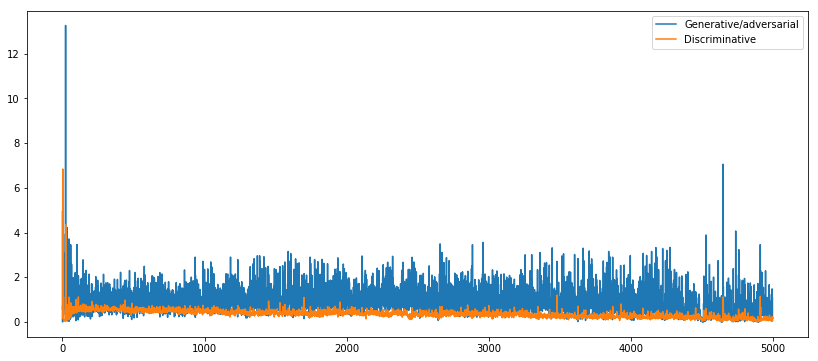

In [110]:
import matplotlib.pyplot as plt
%matplotlib inline
plt.figure(figsize=(14,6))
plt.plot([i[0] for i in history["g"]],label="Generative/adversarial")
plt.plot([i[0] for i in history["d"]],label="Discriminative")
plt.legend()
plt.show()

Cómo se espera que sean las curvas de aprendizaje?

In [ ]:
def train_for_n(nb_epoch=5000, plt_frq=25,BATCH_SIZE=32):

    for e in tqdm(range(nb_epoch)):  
        
        # Make generative images
        image_batch = X_train[np.random.randint(0,X_train.shape[0],size=BATCH_SIZE),:,:,:]    
        noise_gen = np.random.uniform(0,1,size=[BATCH_SIZE,100])
        generated_images = generator.predict(noise_gen)
        
        # Train discriminator on generated images
        X = np.concatenate((image_batch, generated_images))
        y = np.zeros([2*BATCH_SIZE,2])
        y[0:BATCH_SIZE,1] = 1
        y[BATCH_SIZE:,0] = 1
        
        make_trainable(discriminator,True)
        d_loss  = discriminator.train_on_batch(X,y)
        losses["d"].append(d_loss)
    
        # train Generator-Discriminator stack on input noise to non-generated output class
        noise_tr = np.random.uniform(0,1,size=[BATCH_SIZE,100])
        y2 = np.zeros([BATCH_SIZE,2])
        y2[:,1] = 1
        
        make_trainable(discriminator,False)
        g_loss = GAN.train_on_batch(noise_tr, y2 )
        losses["g"].append(g_loss)
        
        # Updates plots
        if e%plt_frq==plt_frq-1:
            plot_loss(losses)
            plot_gen()

### Test it

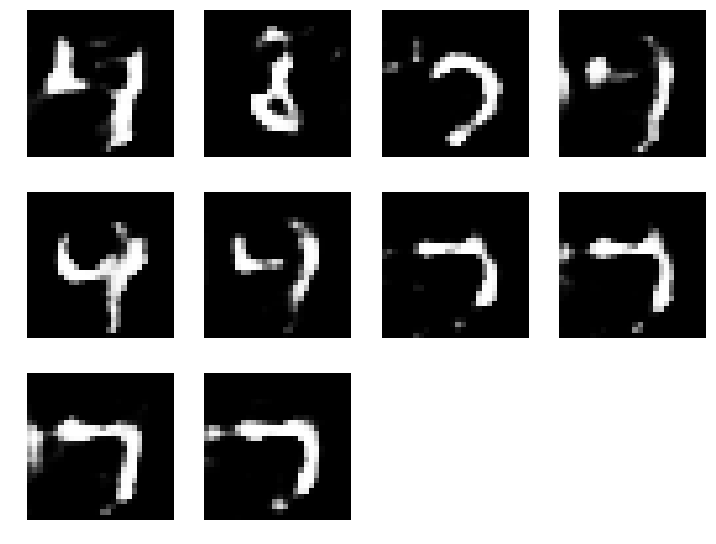

In [112]:
N = 10
noise = np.random.uniform(-1.0, 1.0, size=[N, input_dim]) 

images = G.predict(noise)

import matplotlib.pyplot as plt
plt.figure(figsize=(10,10))
for i in range(images.shape[0]):
    plt.subplot(4, 4, i+1)
    image = images[i, :, :, :]
    image = np.reshape(image, [img_rows, img_cols])
    plt.imshow(image, cmap='gray')
    plt.axis('off')
plt.tight_layout()
plt.show()

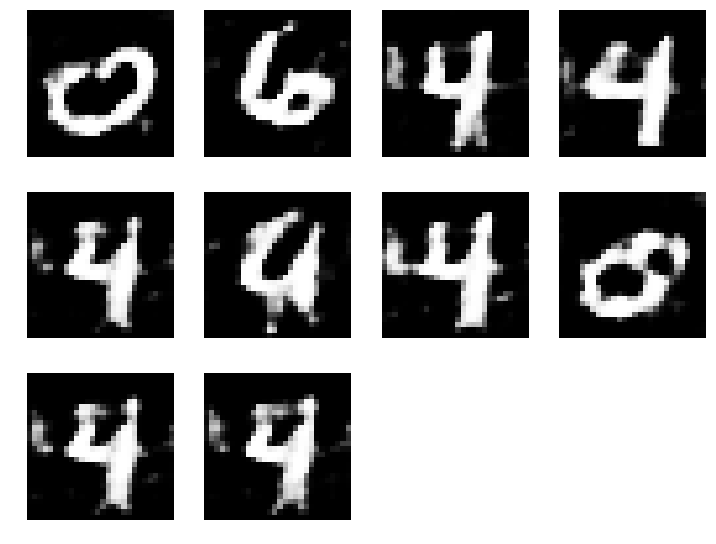

In [86]:
N = 10
noise = np.random.uniform(-1.0, 1.0, size=[N, input_dim]) 

images = G.predict(noise)

import matplotlib.pyplot as plt
plt.figure(figsize=(10,10))
for i in range(images.shape[0]):
    plt.subplot(4, 4, i+1)
    image = images[i, :, :, :]
    image = np.reshape(image, [img_rows, img_cols])
    plt.imshow(image, cmap='gray')
    plt.axis('off')
plt.tight_layout()
plt.show()

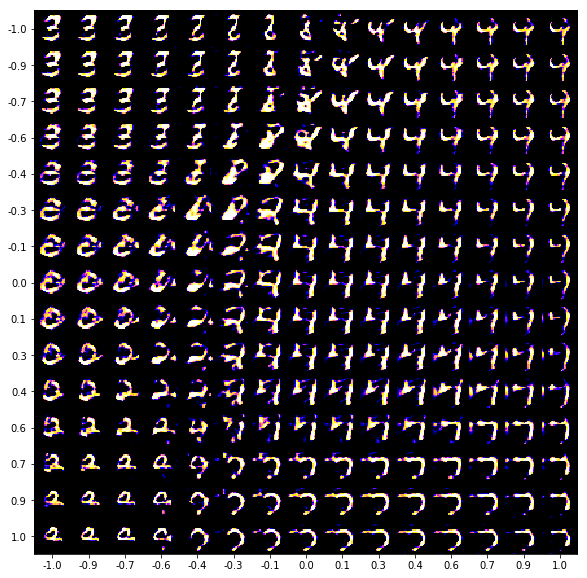

In [113]:
n = 15  # figure with 15x15 images #con mas se ve mas fino
image_size = img_cols
figure = np.zeros((image_size * n, image_size * n))


grid_x = np.linspace(-1, 1, n)
grid_y = np.linspace(-1, 1, n)

for i, yi in enumerate(grid_x):
    for j, xi in enumerate(grid_y):
        z_sample = np.array([[xi, yi]])            
        x_decoded = G.predict(z_sample,batch_size=batch_size)
        figure[i * image_size: (i + 1) * image_size,
               j * image_size: (j + 1) * image_size] = x_decoded[0][:,:,0]
plt.figure(figsize=(10, 10))
plt.imshow(figure,cmap='gnuplot2')
pos = np.arange(image_size/2,image_size*n,image_size)
plt.yticks(pos,np.round(grid_y,1))
plt.xticks(pos,np.round(grid_x,1))
plt.show()

In [35]:
batch_size=8
#sample images from real data
images_train = X_train[np.random.randint(0,X_train.shape[0], size=batch_size), :, :, :]

#sample image from generated data
noise = np.random.uniform(-1.0, 1.0, size=[batch_size, 100])
images_fake = G.predict(noise) #se actualizara por ref?

x = np.concatenate((images_train, images_fake))

#create labels
y = np.ones([2*batch_size, 1])
y[batch_size:, :] = 0

#train discriminator
d_loss = DM.train_on_batch(x, y)

#train generator (or adversarial)
y = np.ones([batch_size, 1])
noise = np.random.uniform(-1.0, 1.0, size=[batch_size, 100])
a_loss = AM.train_on_batch(noise, y)

/home/casapanshop/anaconda2/lib/python2.7/site-packages/keras/engine/training.py:973: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'
